In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats as stats 
from scipy.stats import pearsonr, spearmanr
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statannotations.Annotator import Annotator
import create_dataset
%matplotlib inline

In [2]:
path_data = "../data/"
savedir = "../output/"
path_samples = path_data + "single_events_data/"
metadata = pd.read_csv(path_data + "readMe_Metadata.csv")
measures = pd.read_excel(path_data + "phenotypes.xlsx")
retrain=False

In [11]:
### load syntof
df, markers = create_dataset.createDataset(metadata, path_samples)
print(len(markers))

30


In [13]:
##Mean expression matrix
df_mean = df[markers + ["Subject_name","Sample_name"]]
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()
map_id2diet = {ii:dt for ii,dt in list(zip(measures["ID"].astype(str).values,
                                            measures["Diet"].values))}
df_mean["Diet2"] = df_mean["Subject_name"].astype(str).map(map_id2diet).values

In [15]:
#phenotype processing
measures["ID"] = measures["ID"].astype(str)
measures = measures[measures.ID.isin(df.Subject_name.unique().tolist())]
measures

#rename phenotypes
mapi = pd.read_excel(path_data + "mapping_phenotypes.xlsx")
mapi
[it for it in measures.columns.tolist() if it not in mapi["Abbreviation in text"].tolist()]
mapiii = {old:new for old,new in zip(mapi["Abbreviation in text"].values,mapi["New Definitions"].values)}
measures = measures.rename(columns=mapiii)
measures
measures["Steatosis (0-Liver HU)"] = 1- measures["Steatosis (0-Liver HU)"]


#merge data
df = df[df.Subject_name.isin(measures.ID.unique().tolist())]
df
df = df.merge(measures.iloc[:, :10], left_on="Subject_name", right_on="ID")

measures["ID"] = measures["ID"].astype(str)
measures = measures[measures.ID.isin(df.Subject_name.unique().tolist())]
measures
df_mean = df[markers + ["Subject_name","Sample_name"]]
df_mean = df_mean.groupby(["Subject_name","Sample_name"]).mean()
df_mean = df_mean.reset_index()

#drop covariables
to_drop = ["Status", "Hemisphere_Frozen", "Nx_Time"]
for it in measures.columns:
    if "Base" in it:
        to_drop.append(it)
for it in to_drop:
    if it in measures.columns:
        measures.drop(to_drop, axis=1, inplace=True)
        measures

to_drop = ['ID',
         # 'Diet',
        'Status',
         'Hemisphere_Frozen',
          "Subject_name",
          'Nx_Time']
com = [it for it in measures.columns.tolist() if it not in to_drop]
len(com)



61

In [16]:
measures.isna().sum()

ID                     0
Diet                   0
BMI                    0
IV GTT Insulin AUC     0
24 Hour Activity       0
                      ..
# Awakenings Night     0
% Time Alone           0
% Time Body Contact    0
% Time Depressed       0
% Time Anxiety         0
Length: 62, dtype: int64

In [17]:
with_diet = True
if not with_diet:
    com.remove("Diet")
    savedir += "No_diet_"


meta = df_mean[["Subject_name"] + markers].merge(measures, left_on="Subject_name", right_on="ID")
meta = meta.loc[meta.isna().sum(1)==0, :]
# meta.drop(to_drop, axis=1, inplace=True)
#meta = meta.loc[:,meta.isna().sum(0)==0]
#meta = meta.loc[:, meta.dtypes=="float"]
#meta.drop("TM31_Ttau", axis=1, inplace=True)
meta = meta.astype(float)
meta.reset_index(inplace=True, drop=True)
col = [it for it in meta.columns.tolist() if it not in markers]
X = meta[com].values #[col_info["HEADING"].tolist()].values
X.shape

(36, 61)

In [18]:
meta[com].to_csv(savedir + "input_phenotypes.csv", index=None)

# With feature selection

In [19]:
if retrain:
    import shap
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    from sklearn.linear_model import Ridge, ElasticNet
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import RepeatedKFold, LeaveOneOut,KFold, RepeatedStratifiedKFold, StratifiedKFold
    from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
    from sklearn.feature_selection import VarianceThreshold, SelectKBest
    from sklearn.feature_selection import f_regression
    # from sklearn_relief import Relief
    # import xgboost
    #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    np.random.seed(31415) 
    list_k = [4,8,12,16,20,30, 40,50,80, 100, 150]
    list_models = ['Linear Regression', #'KNN', 
                  'Decision Tree',] 
        
                    #'Random Forest']
    models = {
                        'Linear Regression':LinearRegression(),
                        #"Logistic Regression":LogisticRegression(),
                        'Decision Tree': DecisionTreeRegressor(random_state=1),
                                #'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                               # 'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                               # 'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                                'Random Forest': RandomForestRegressor(random_state=1),
                                'KNN': KNeighborsRegressor(),
                                #'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                                #'XGBoost': XGBClassifier(n_jobs=-1, booster='gblinear', objective='binary:logistic')
                            }
    methods = ["shap"]#,"normal"]
    test_feats = [5, 10, 20,40,60,X.shape[-1]]
    index = [mm+"_"+m+"_"+method+"_"+str(ff) for mm in list_models for m in markers for method in methods for ff in test_feats]
    
    # res = pd.DataFrame(np.zeros((len(list_de)*len(list_models), 8)), index=list_de, columns=["n_features", "marker","algo", 'Pearson','Spearman', 'Pvalue(Pearson)','Pvalue(Spearman)','MAPE' ])
    res = pd.DataFrame(np.zeros((len(markers)*len(list_models)*len(methods)*len(test_feats), 9)),
                       index=index, columns=["n_features", "marker","algo", 'Pearson','Spearman',
                                                                                           'Pvalue(Pearson)','Pvalue(Spearman)','MAPE', "Method"])
    
    y_preds = {mm+"_"+m:pd.DataFrame(np.zeros((len(X), 1)), columns=['y_pred']) for mm in list_models for m in markers}
    
    inner_cv = StratifiedKFold(n_splits=10,shuffle=True)
    n_out_splits = 10
    outer_cv2 = RepeatedStratifiedKFold(n_splits=n_out_splits,n_repeats=50,  random_state=1)
    outer_cv = StratifiedKFold(n_splits=10,shuffle=True)
    outer_cv_results = {key: [] for key in ["marker","outer_split", "n_features", "algo", "mae", "method"]}
    
    loo = LeaveOneOut()
    
    w_out = {it+"_"+mm+"_"+method+"_"+str(ff):np.zeros((n_out_splits, X.shape[1])) for it in list_models for mm in markers for method in methods for ff in test_feats}
    
    w_algo = {it+"_"+mm+"_"+method+"_"+str(ff):np.zeros((len(X), X.shape[1])) for it in list_models for mm in markers for method in methods for ff in test_feats}
    
    
    # method="normal"
    for method in methods:
        print(method)
        for algo in list_models:
            for it in markers:
                y = meta[it].values
                #print(y.shape)
                for ff, n_features in enumerate(test_feats):

                    for i1, (train_index, test_index) in enumerate(outer_cv.split(X, X[:,0])):
                        X_train, X_test = X[train_index, :], X[test_index, :]
                        y_train, y_test = y[train_index], y[test_index]
                    
                    
                        inner_cv_results = {key: [] for key in ["marker","outer_split", "inner_split", "n_features", "algo", "mae", "index"]}
                     # print(n_features)
                        # y_preds_inner = {mm+"_"+m+"_"+str(ff) :pd.DataFrame(np.zeros((len(X_train), 1)), columns=['y_pred']) for mm in models for m in markers for ff in test_feats }
                        # y_inner = {mm+"_"+m+"_"+str(ff) :pd.DataFrame(np.zeros((len(X_train), 1)), columns=['y_pred']) for mm in models for m in markers for ff in test_feats }
                        nb_inner = len(list(inner_cv.split(X_train, X_train[:,0])))
                        w_in = np.zeros((nb_inner, X.shape[1])) 
                        name = algo+"_"+it+"_"+method+"_"+str(n_features)
                        for i2, (train_inner, test_inner) in enumerate(inner_cv.split(X_train, X_train[:,0])):
                                X_train_inner, X_test_inner = X_train[train_inner,:], X_train[test_inner,:]
                                y_train_inner, y_test_inner = y_train[train_inner], y_train[test_inner]
    
    
                                #for k in list_k:
                                clf = models[algo]
                                # name2 = algo+"_"+it+"_"+str(n_features)
                                
    
                                # ft = Relief(n_features=n_features)
                                scaler = StandardScaler()
                                pipe = Pipeline([("scale", scaler),
                                       # ("selection", ft),
                                    #("featureselection" , VarianceThreshold()),
                                                 #("featureSelection", SelectKBest(f_regression, k=k)),
                                          #("reduce_dims", PCA()),
                                         ("model", clf)
                                         ])
    
                                pipe.fit(np.array(X_train_inner), np.array(y_train_inner))
                                # if algo in ['LASSO', 'Ridge']:
                                    # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
                                # else:
                                y_pred = np.array(pipe.predict(np.array(X_test_inner)))
                                #ind = ft.w_
                                if method == "normal":
                                    if algo =="Linear Regression":
                                        w_ = np.abs(clf.coef_)
                                    else:
                                         w_ = clf.feature_importances_
                                elif method=="shap":
                                    X_std = scaler.transform(np.array(X_test_inner))
                                    if algo =="Linear Regression":
                                        explainer = shap.explainers.Linear(clf,X_std)
                                        shap_values = explainer(X_std).values
                                    else:
                                        explainer = shap.TreeExplainer(clf)
                                        shap_values = explainer(X_std).values
                                    w_ = np.abs(shap_values).mean(0)
                                feat_indices = np.flip(np.argsort(w_), 0)[0:n_features]
    
                                w_in[i2, feat_indices] = 1 
                                    #y_preds_inner[name].loc[test_inner,:] = y_pred
                                    #y_inner[name].loc[test_inner,:] = y_test_inner
    
                                inner_cv_results["outer_split"].append(i1 + 1)
                                inner_cv_results["inner_split"].append(i2 + 1)
                                inner_cv_results["n_features"].append(n_features)
                                inner_cv_results["index"].append(i2)

                                inner_cv_results["algo"].append(algo)
    
                                inner_cv_results["marker"] = it
                                    #inner_cv_results["pearson"].append(pearsonr(y_test_inner, y_pred)[0])
                                    #inner_cv_results["spearman"].append(spearmanr(y_test_inner, y_pred)[0])
                                inner_cv_results["mae"].append(mean_absolute_error(y_test_inner, y_pred))
                        # for algo in list_models:
                        #         for k in list_k:
                        #             name = algo +"_"+it +"_"+str(k)
                        #             sp, spp = spearmanr(y_inner[name].values.reshape(-1), y_preds_inner[name].values.reshape(-1))
                        #             pearson, pearsonp = pearsonr(y_inner[name].values.reshape(-1), y_preds_inner[name].values.reshape(-1))
                        #             res_inner.loc[name, "n_features"] = k
                        #             res_inner.loc[name, "marker"] = it
                        #             res_inner.loc[name, "algo"] = algo
                        #             res_inner.loc[name, 'Pearson'] = pearson
                        #             res_inner.loc[name, 'Pvalue(Pearson)'] = pearsonp
                        #             res_inner.loc[name, 'Spearman'] = sp
                        #             res_inner.loc[name, 'Pvalue(Spearman)'] = spp
                        #             res_inner.loc[name, 'MAPE'] = mean_absolute_percentage_error(y_inner[name], y_preds_inner[name])
    
                        # best_ = res_inner[res_inner.marker ==it]
                        # best_ = best_[best_.Pearson == best_.Pearson.max()]
    
                        best_feat = inner_cv_results["n_features"][np.where(inner_cv_results["mae"]==np.min(inner_cv_results["mae"]))[0][0]]
    
                        # print(best_feat)
                        valid_index = np.where(np.asarray(inner_cv_results["n_features"]) == best_feat)[0]
                        w_best = w_in.sum(0)
                        #print(w_best.shape)
    
                        indx = sorted(range(len(w_best)), key=lambda i: w_best[i])[-n_features:]
                        w_final = np.zeros_like(w_best)
                        w_final[indx] = 1
                        #w_best[w_best<w_in.shape[0]] =0
                        #w_best[w_best>0]=1
                        w_out[name][i1,:] = w_final


                        # best_ = pd.DataFrame(inner_cv_results)
                        # best_ = best_[best_.marker ==it]
                        # best_ = (best_.query("outer_split == @i1+1")
                        #             .groupby(["n_features", "algo"])
                        #             .agg(mean_mae=("mae", "mean"),
                        #                  std_mae=("mae", "std"))
                        #             .sort_values(by=["mean_mae", "std_mae"], ascending=[True, True])
                        #             .head(1)
                        #             ).reset_index()
                        # #print(best_)
                        # best_k = best_["n_features"].values[0]
                        # best_model = best_["algo"].values[0]
                        scaler = StandardScaler()
                        pipe = Pipeline([("scale", scaler),
                                    #("featureselection" , VarianceThreshold()),
                                                 #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                          #("reduce_dims", PCA()),
                                         ("model", models[algo])
                                         ])
                        indexxx = np.where(w_final>0)[0]
                        pipe.fit(np.array(X_train[:,indexxx]), np.array(y_train))
                                # if algo in ['LASSO', 'Ridge']:
                                    # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
                                # else:
                        y_pred = np.array(pipe.predict(np.array(X_test[:, indexxx])))
                             # Store results
                        outer_cv_results["marker"].append(it)
                        outer_cv_results["outer_split"].append(i1)
                        outer_cv_results["n_features"].append(best_feat)
                        outer_cv_results["algo"].append(algo)
                        outer_cv_results["method"] = method
                        outer_cv_results["mae"].append(mean_absolute_error(y_test, y_pred))
                    out_selection = pd.DataFrame(outer_cv_results)
                    out_selection = out_selection[(out_selection.marker == it)
                                                  &(out_selection.algo==algo)].sort_values("mae")
                    outer_selection_split = out_selection.iloc[0]["outer_split"]
                    best_it = out_selection.iloc[0]["outer_split"]
                    w_best = w_out[name][best_it, :]
                    # w[w>0] =1
                    # w_best = w.sum(0)
                    # print(w_best.shape)
                    # w_best[w_best<w.shape[0]] =0
                    # w_best[w_best>0]=1
                    # name = algo+"_"+it+"_"+method
    
                    w_algo[name] = w_best
                    feat_index = np.where(w_best>0)[0]
                    # if out_selection.iloc[0]["n_features"] == X.shape[-1]:
                    #     feat_index = [it for it in range(X.shape[-1])]
                    tmp = pd.DataFrame(columns=range(len(X)))
                    for i3, (train_index, test_index) in enumerate(outer_cv2.split(X, X[:,0])):
                        X_train, X_test = X[train_index, :], X[test_index, :]
                        y_train, y_test = y[train_index], y[test_index]
                        scaler = StandardScaler()
                        clf =models[algo]
                        pipe = Pipeline([("scale", scaler),
                                    #("featureselection" , VarianceThreshold()),
                                                 #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                          #("reduce_dims", PCA()),
                                         ("model", clf)
                                         ])
                        pipe.fit(np.array(X_train[:,feat_index]), np.array(y_train))
                        y_pred = np.array(pipe.predict(np.array(X_test[:, feat_index])))
                        # y_preds[name].loc[test_index, :] = y_pred.reshape((-1,1))#[0]
                        ans_list = [None] * len(X)
                        start = 0
                        for j in test_index:
    
                            ans_list[j] = y_pred[start]
                            start += 1
                            tmp.loc[len(tmp),:]=ans_list
                        # Use SHAP to explain predictions
                        X_std = scaler.transform(np.array(X_test[:,feat_index]))
                        if algo =="Linear Regression":
                            explainer = shap.explainers.Linear(clf, X_std)
                            shap_values = explainer.shap_values(X_std)
                        else:
                            explainer = shap.TreeExplainer(clf)
                            shap_values = explainer.shap_values(X_std)
                        w_ = np.abs(shap_values).mean(0)
    
                        # y_preds[name].loc[test_index, :] = y_pred[0]
                    # y_preds[algo] = tmp.mean(0).values.astype(float).reshape(-1)
                    y_preds[name] = tmp.mean(0).values.astype(float).reshape(-1)
                    sp, spp = spearmanr(y, y_preds[name].astype(float).reshape(-1))
                    pearson, pearsonp = pearsonr(y, y_preds[name].astype(float).reshape(-1))
                    res.loc[name, "n_features"] = n_features
                    res.loc[name, "marker"] = it
                    res.loc[name, "algo"] = algo
                    res.loc[name, 'Pearson'] = pearson
                    res.loc[name, 'Pvalue(Pearson)'] = pearsonp
                    res.loc[name, 'Spearman'] = sp
                    res.loc[name, 'Pvalue(Spearman)'] = spp
                    res.loc[name, "Method"] = method
                    res.loc[name, 'MAPE'] = mean_absolute_percentage_error(y, y_preds[name])
                    print(name)
                    print(pearson)



In [20]:
if retrain:
    final = []
    for mm in res.Method.unique():
        for it in res.marker.unique():
            tmp = res[(res.marker ==it) &(res.Method==mm)]
            # tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
            final.append(tmp)
    final =pd.concat(final)
    # final = final[(final["Pvalue(Pearson)"] <=0.05) & ( final["Pearson"]>0)]
    # final = final[(final["Pvalue(Spearman)"] <=0.06) & ( final["Spearman"]>0)]
    res.to_csv(savedir + "models_with_features_selection_SHAP_all_nb_features_GOOD_stratified.csv", index="None")
    final = final[(final["Pvalue(Spearman)"] <=0.05) & ( final["Spearman"]>0)]
    final
    finalf = []
    for it in final.marker.unique():
            tmp = final[(final.marker ==it) ]
            tmp = tmp[tmp.n_features == tmp.n_features.min()]
            finalf.append(tmp)
    final =pd.concat(finalf)
    final
    finalf = []
    for it in final.marker.unique():
            tmp = final[(final.marker ==it) ]
            tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
            finalf.append(tmp)
    final =pd.concat(finalf)
    final

In [21]:
res= pd.read_csv(savedir + "Phenotype_models_with_features_selection_SHAP_all_nb_features.csv",index_col=0)
res
# res

n_features  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5           5.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10         10.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20         20.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40         40.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60         60.0   
...                                                  ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10        10.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20        20.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40        40.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60        60.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61        61.0   

                                                              marker  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5         89Y_EAAT1_(Y89Di)   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10        89Y_EAAT1_(Y89Di)   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20        89Y_EAAT1_(Y89Di)   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40        89Y_EAAT1_(Y89Di)   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60        89Y_EAAT1_(Y89Di)   
...                                                              ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10  176Lu_SLC6A8_(Lu176Di)   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20  176Lu_SLC6A8_(Lu176Di)   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40  176Lu_SLC6A8_(Lu176Di)   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60  176Lu_SLC6A8_(Lu176Di)   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61  176Lu_SLC6A8_(Lu176Di)   

                                                           algo   Pearson  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5    Linear Regression  0.345851   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10   Linear Regression  0.472647   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20   Linear Regression -0.075519   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40   Linear Regression  0.262256   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60   Linear Regression -0.165894   
...                                                         ...       ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10      Decision Tree  0.259006   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20      Decision Tree  0.070909   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40      Decision Tree -0.099386   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60      Decision Tree -0.203442   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61      Decision Tree -0.155950   

                                              Spearman  Pvalue(Pearson)  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5    0.305277         0.038818   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10   0.445560         0.003604   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20  -0.018533         0.661566   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40   0.175547         0.122301   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60  -0.210039         0.333564   
...                                                ...              ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10  0.264350         0.127171   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20  0.041441         0.681103   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40 -0.130759         0.564139   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60 -0.205148         0.234020   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61 -0.176834         0.363745   

                                              Pvalue(Spearman)      MAPE  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5            0.070216  0.191335   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10           0.006463  0.170800   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20           0.914566  0.318983   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40           0.305793  0.310766   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60           0.218874  0.372004   
...                                                        ...       ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10          0.119237  0.084285   
Decision Tree_176Lu_SLC6A8

In [22]:
final = []
for it in res.marker.unique():
    tmp = res[(res.marker ==it)&(res.Method=="shap")]
    tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
    final.append(tmp)
final =pd.concat(final)
final = final[final["Pvalue(Spearman)"] <=0.05]
len(final)

26

In [23]:
if retrain:
    all_weight_index = pd.DataFrame(w_algo).T
    all_weight_index.to_csv(savedir + "Phenotype_models_with_features_selection_SHAP_all_nb_features_WEIGHTS.csv", index="None")


In [24]:
all_weight_index = pd.read_csv(savedir 
                               + "Phenotypes_models_with_features_selection_SHAP_all_nb_features_WEIGHTS.csv",index_col=0)
all_weight_index

0    1    2    3    4    5  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5    1.0  0.0  0.0  0.0  0.0  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10   0.0  0.0  0.0  0.0  0.0  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20   1.0  0.0  0.0  0.0  0.0  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40   1.0  0.0  0.0  1.0  1.0  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60   1.0  0.0  1.0  1.0  1.0  1.0   
...                                           ...  ...  ...  ...  ...  ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10  0.0  0.0  0.0  0.0  0.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20  1.0  0.0  0.0  1.0  0.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40  0.0  1.0  1.0  1.0  1.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60  0.0  1.0  1.0  1.0  1.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61  1.0  1.0  1.0  1.0  1.0  1.0   

                                                6    7    8    9  ...   51  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5    0.0  0.0  0.0  1.0  ...  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10   0.0  0.0  0.0  1.0  ...  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20   0.0  0.0  0.0  1.0  ...  1.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40   0.0  1.0  0.0  1.0  ...  1.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60   1.0  1.0  1.0  1.0  ...  1.0   
...                                           ...  ...  ...  ...  ...  ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10  0.0  1.0  0.0  0.0  ...  0.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20  0.0  1.0  0.0  0.0  ...  0.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40  1.0  1.0  1.0  1.0  ...  0.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60  1.0  1.0  1.0  1.0  ...  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61  1.0  1.0  1.0  1.0  ...  1.0   

                                               52   53   54   55   56   57  \
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5    0.0  0.0  0.0  0.0  0.0  0.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10   0.0  0.0  0.0  0.0  1.0  1.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20   1.0  0.0  1.0  0.0  1.0  1.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40   1.0  0.0  1.0  1.0  1.0  1.0   
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60   1.0  1.0  1.0  1.0  1.0  1.0   
...                                           ...  ...  ...  ...  ...  ...   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10  0.0  0.0  0.0  0.0  0.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20  0.0  0.0  0.0  0.0  0.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40  1.0  1.0  1.0  1.0  1.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60  1.0  1.0  1.0  1.0  1.0  1.0   
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61  1.0  1.0  1.0  1.0  1.0  1.0   

                                               58   59   60  
Linear Regression_89Y_EAAT1_(Y89Di)_shap_5    0.0  0.0  0.0  
Linear Regression_89Y_EAAT1_(Y89Di)_shap_10   0.0  0.0  1.0  
Linear Regression_89Y_EAAT1_(Y89Di)_shap_20   1.0  1.0  0.0  
Linear Regression_89Y_EAAT1_(Y89Di)_shap_40   1.0  0.0  1.0  
Linear Regression_89Y_EAAT1_(Y89Di)_shap_60   1.0  1.0  1.0  
...                                           ...  ...  ...  
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_10  0.0  0.0  0.0  
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_20  1.0  0.0  1.0  
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_40  1.0  1.0  1.0  
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_60  1.0  1.0  1.0  
Decision Tree_176Lu_SLC6A8_(Lu176Di)_shap_61  1.0  1.0  1.0  

[360 rows x 61 columns]

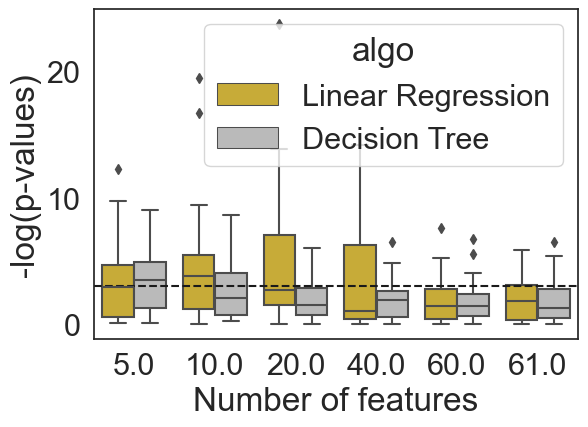

In [25]:
res["-log(p-values)"] = -np.log(res["Pvalue(Spearman)"].values)
shap_m= res[res.Method=="shap"]
sns.set(style="white", font_scale=2)
ax = sns.boxplot(data=shap_m, x="n_features", y="-log(p-values)", hue="algo", palette={"Linear Regression":"#dfb920", "Decision Tree":"#BABABA"})
ax.set_xlabel("Number of features")
ax.axhline(-np.log(0.05), c="k", linestyle="--")
# plt.savefig(savedir + "boxplot_shap_n_features.svg")
plt.tight_layout()
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\('
<>:23: SyntaxWarning: invalid escape sequence '\('
<>:10: SyntaxWarning: invalid escape sequence '\('
<>:23: SyntaxWarning: invalid escape sequence '\('
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/3179992351.py:10: SyntaxWarning: invalid escape sequence '\('
  final_no_feat_select["marker_name"] = final_no_feat_select["marker"].str.split("_\(", expand=True)[0].str.split("_",n=1, expand=True)[1]
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/3179992351.py:23: SyntaxWarning: invalid escape sequence '\('
  tres["marker_name"] = tres["marker"].str.split("_\(", expand=True)[0].str.split("_",n=1, expand=True)[1]


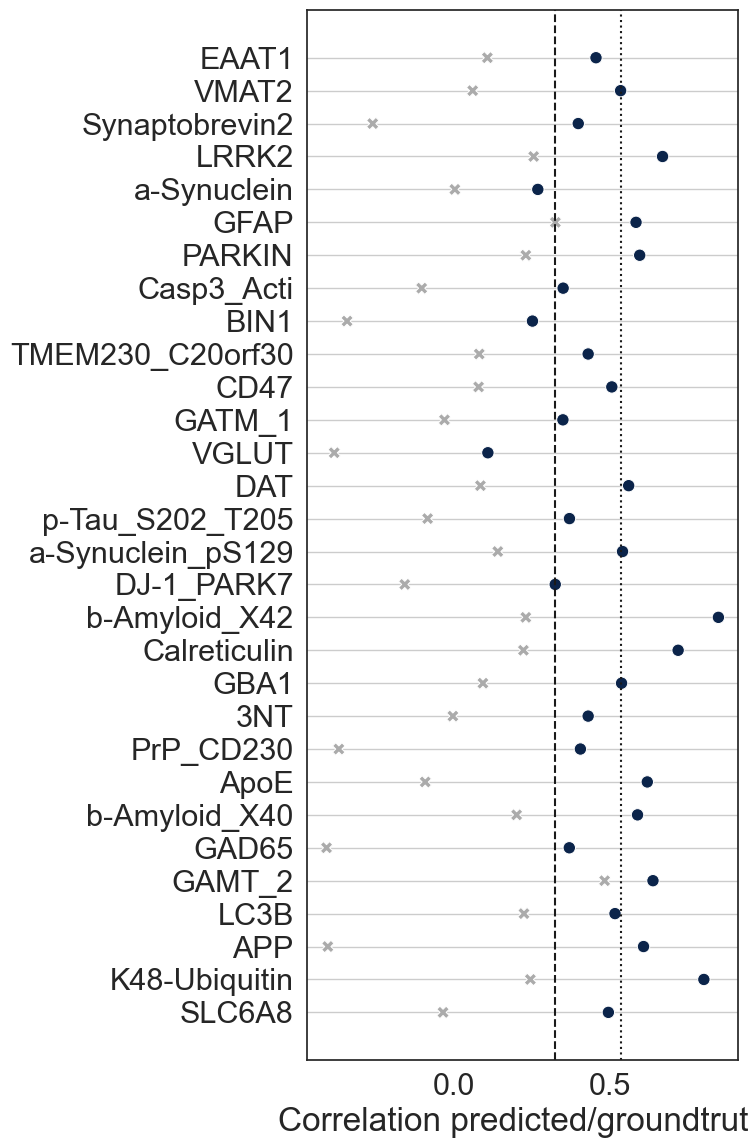

In [27]:
final_no_feat_select = []

for it in res.marker.unique():
        tmp = res[(res.marker ==it) &(res.Method=="shap")&(res["n_features"] ==61)]
        tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
        final_no_feat_select.append(tmp)
final_no_feat_select =pd.concat(final_no_feat_select)
final_no_feat_select["-log(Pvalue)"] = -np.log(final_no_feat_select["Pvalue(Spearman)"]).values

final_no_feat_select["marker_name"] = final_no_feat_select["marker"].str.split("_\(", expand=True)[0].str.split("_",n=1, expand=True)[1]
final_no_feat_select["style"] = "x"

tres = []

for it in res.marker.unique():
    tmp = res[(res.marker ==it)&(res.Method=="shap")]
    tmp = tmp[tmp.Spearman == tmp.Spearman.max()]
    tres.append(tmp)
tres =pd.concat(tres)
#tres = tres[tres["Pvalue(Spearman)"] <=0.05]
tres
tres["-log(Pvalue)"] = -np.log(tres["Pvalue(Spearman)"]).values
tres["marker_name"] = tres["marker"].str.split("_\(", expand=True)[0].str.split("_",n=1, expand=True)[1]
sns.set(font_scale=2, style="white")

fig, ax = plt.subplots(figsize=(8, 12))
ax.grid(axis='y')

sns.scatterplot(data=final_no_feat_select, x="Spearman", y="marker_name",size="-log(Pvalue)", ax=ax, color="#ABABAB",style="style", markers=["X"],sizes=(80, 80))
# sns.scatterplot(data=final_no_diet, x="Spearman", y="marker_name",size="-log(Pvalue)", ax=ax, color="#ABABAB",style="style", markers=["s"])
sns.scatterplot(data=tres, x="Spearman", y="marker_name",size="-log(Pvalue)", ax=ax, color="#0b244a",sizes=(80, 80))
tt = tres[tres["Pvalue(Spearman)"]>0.05].Spearman.max()
ax.get_legend().remove()
ax.axvline(x=tt, c="k", linestyle="--",label="P>=0.05")
tt = tres[tres["Pvalue(Spearman)"]<=0.001].Spearman.min()
ax.axvline(x=tt, c="k", linestyle=":", label="P<=0.001")

ax.set_ylabel("")
ax.set_xlabel("Correlation predicted/groundtruth")

plt.savefig(savedir + "Figure4A.svg")
plt.tight_layout()
plt.show()

In [28]:
if retrain:
    fig, axes = plt.subplots(4,7, figsize=(35, 8))
    axes = axes.flatten()
    for ii,it in enumerate(final.index.tolist()):
        ax= axes[ii]
        pp, pval = spearmanr(y_preds[it].reshape(-1), meta[final.loc[it,"marker"]].values.reshape(-1))
        sns.regplot( x=meta[final.loc[it,"marker"]],y=y_preds[it], ax=ax, color="#0b244a")
        ax.set_xlabel("")#Predicted values")
        ax.set_ylabel("")#Ground truth")
        ax.set_title(it.split("_(")[0].split("_",2)[2])
        ax.text(meta[final.loc[it,"marker"]].min(),np.quantile(y_preds[it], 0.9), "SP: %s (%s)"%(str(np.round(pp,2)), str(np.round(pval, 3))))
        
    plt.savefig(savedir + "Supp Fig4.svg")
    plt.tight_layout()
    plt.show()

In [29]:
final_wight = all_weight_index.loc[final.index.tolist(),:]
final_wight["marker"] = [it.split("_(")[0].split("_",2)[-1] for it in final_wight.index.tolist()]
final_wight.set_index("marker", drop=True, inplace=True)
final_wight.columns =com

In [32]:
# from scipy.stats import pearsonr, spearmanr
# import numpy as np


# from matplotlib.colors import LinearSegmentedColormap
# mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", 'white', "#0b244a"], N=256)
# hh = meta[com + markers] #final["marker"].unique().tolist()]
# rho = hh.corr(method="spearman")
# pval = hh.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
# feat_corr = rho.loc[markers,com] #final["marker"].unique().tolist(), com]
# feat_corr.index = [it.split("_(",1)[0].split("_",1)[-1] for it in feat_corr.index.tolist()]
# pval = pval.loc[markers, com] #final["marker"].unique().tolist(),com]

# pval.index = [it.split("_(",1)[0].split("_",1)[-1] for it in pval.index.tolist()]

# p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
# df1 = feat_corr.stack().reset_index()
# df1.columns = ['SynTOF markers','Phenotypes','Spearman correlation']
# df1

# df2 = pval.stack().reset_index()
# df2.columns = ['SynTOF markers','Phenotypes','Pvalue']
# df1 = df1.merge(df2, on=['SynTOF markers','Phenotypes']
#                )
# df1 = df1[df1.Phenotypes != "Diet"]


# from statsmodels.stats.multitest import multipletests
# qvalue  =multipletests(df1["Pvalue"].values, method="fdr_bh")[1]
# df1["Adjusted Pvalue"] = qvalue


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/2549952916.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


60
60


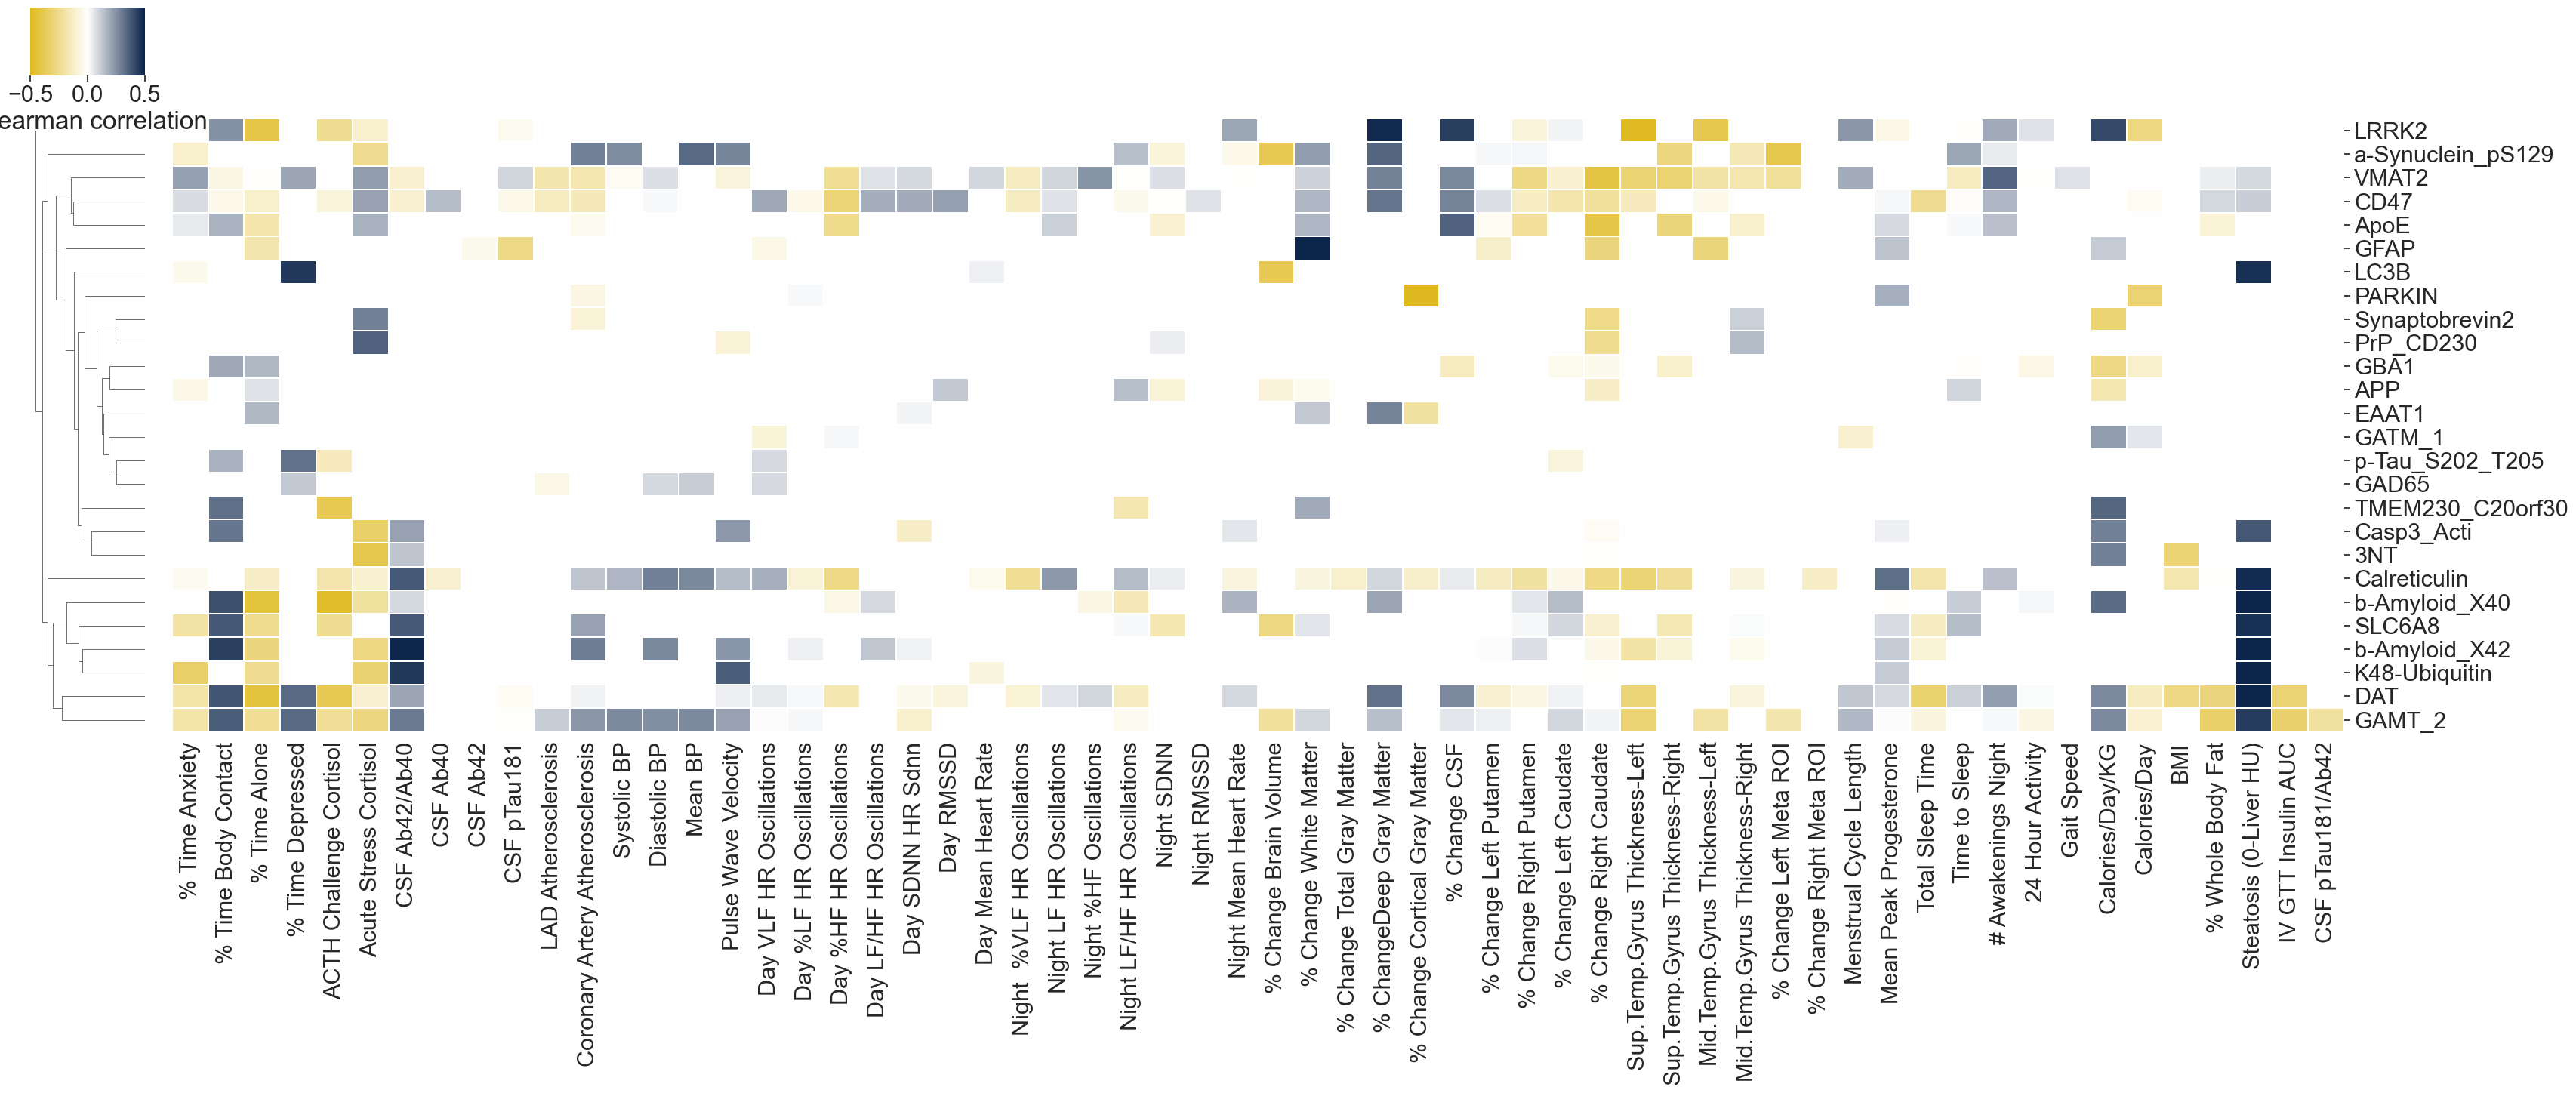

In [34]:
from scipy.stats import pearsonr, spearmanr
import numpy as np


from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", 'white', "#0b244a"], N=256)
hh = meta[com + final["marker"].unique().tolist()]
rho = hh.corr(method="spearman")
pval = hh.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)


feat_corr = rho.loc[final["marker"].unique().tolist(), com]
feat_corr.index = [it.split("_(",1)[0].split("_",1)[-1] for it in feat_corr.index.tolist()]
pval = pval.loc[final["marker"].unique().tolist(),com]

pval.index = [it.split("_(",1)[0].split("_",1)[-1] for it in pval.index.tolist()]

p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))

colss =com

# mask = pval[pval<=0.05]
# # mask = rho[np.abs(rho)>0.15]
# mask[~mask.isna()] = 1
# mask[mask.isna()] = 0
mask = final_wight.loc[feat_corr.index.tolist(), ]
feat_corr =mask.values*feat_corr


feat_corr
to_keep = feat_corr.sum(0)[feat_corr.sum(0)!=0].index.tolist()
feat_corr = feat_corr[to_keep]
if "Diet" in to_keep:
    to_keep.remove("Diet")
    feat_corr.drop("Diet", axis=1, inplace=True)
feat_corr
p = p[to_keep]
print(len(to_keep))

oreder = mapi[mapi["New Definitions"].isin(to_keep)].sort_values("Final Reorder")["New Definitions"].values
print(len(oreder))
tick_la = [it.replace("\n ", "_") for it in oreder]
gg = sns.clustermap(feat_corr[oreder], figsize=(35, 15),cmap=mycmap, dendrogram_ratio=(0.05,0.1), linewidth=0.2, vmin=-0.5, vmax=0.5,col_cluster=False,
                    xticklabels=tick_la,
                    cbar_kws={"shrink":0.2, "label":"Spearman correlation","orientation":'horizontal' })#, annot=p, fmt="s",)
gg.ax_cbar.set_position([0, 0.95, gg.ax_row_dendrogram.get_position().width, 0.02])

plt.tight_layout()
# plt.savefig(savedir + "univaritate_feat_importance_all_phenotypes_with_features_selection.svg")
plt.show()

In [35]:
import shap
from mlconfound.stats import partial_confound_test
from mlconfound.plot import plot_null_dist, plot_graph
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, LeaveOneOut,KFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_selection import f_regression
# from causalml.inference.meta import BaseSRegressor, BaseTRegressor#, BaseXRegressor, BaseRRegressor
from sklearn.linear_model import LinearRegression
# from causalml.inference.meta import LRSRegressor

shap_dico = {}
shap_tmp = {}
n_out_splits = 10
outer_cv2 = RepeatedStratifiedKFold(n_splits=n_out_splits,n_repeats=50,  random_state=1)
models = {
                    'Linear Regression':LinearRegression(),
                    #"Logistic Regression":LogisticRegression(),
                    'Decision Tree': DecisionTreeRegressor(random_state=1),
                            #'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                           # 'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                           # 'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                            'Random Forest': RandomForestRegressor(random_state=1),
                            'KNN': KNeighborsRegressor(),
                            #'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                            #'XGBoost': XGBClassifier(n_jobs=-1, booster='gblinear', objective='binary:logistic')
                        }
shap_values_per_cv = dict()
cate_per_cv = dict()
mean_ate_per_cv = dict()
for it in final.index.tolist():
    ## Create keys for each sample
    shap_values_per_cv[it] = {} 
    cate_per_cv[it] = {} 
    mean_ate_per_cv[it] = {} 
y_preds = {}
confounding_score = pd.DataFrame(columns=["marker", "model", "P-value"])
for jj,it in final.iterrows():
    y = meta[it["marker"]]
    algo= it["algo"]
    name = jj
           

    w_best = all_weight_index.loc[jj,:]
    feat_index = np.where(w_best>0)[0]

    shap_tmp = {}
    for kj in range(len(X)):
        shap_tmp[kj] = []
    cate_tmp = {}
    for kj in range(len(X)):
        cate_tmp[kj] = []
    tmp = pd.DataFrame(columns=range(len(X)))
    tmp_ate=[]
    for i3, (train_index, test_index) in enumerate(outer_cv2.split(X,X[:,0])):
                    X_train, X_test = X[train_index, :], X[test_index, :]
                    y_train, y_test = y[train_index], y[test_index]
                    clf = models[algo]
                    scaler = StandardScaler()
                    pipe = Pipeline([("scale", scaler),
                                #("featureselection" , VarianceThreshold()),
                                             #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                      #("reduce_dims", PCA()),
                                     ("model", clf)
                                     ])
                    pipe.fit(np.array(X_train[:,feat_index]), np.array(y_train))
                    clf2 = models[algo]
                    scaler2 = StandardScaler()
                    pipe2 = Pipeline([("scale", scaler2),
                                #("featureselection" , VarianceThreshold()),
                                             #("featureSelection", ReliefF(),# SelectKBest(f_regression, k=int(best_k))),
                                      #("reduce_dims", PCA()),
                                     ("model", clf2)
                                     ])
                    # learner_s = BaseSRegressor(learner=pipe2)
                    treat = X_train[:,0]
                    treat[treat==2] = 0
                    feat_index_t = feat_index
                    if 0 in feat_index_t:
                        feat_index_t = feat_index_t[1:]
                    # learner_s.fit(X=np.array(X_train[:,feat_index_t]), treatment=treat, y=np.array(y_train))
                    y_pred = np.array(pipe.predict(np.array(X_test[:, feat_index])))
                    # y_preds[name].loc[test_index, :] = y_pred.reshape((-1,1))#[0]
                    ans_list = [None] * len(X)
                    start = 0
                    for j in test_index:

                        ans_list[j] = y_pred[start]
                        start += 1
                        tmp.loc[len(tmp),:]=ans_list
                    # Use SHAP to explain predictions
                    X_std = scaler.transform(np.array(X_test[:, feat_index]))
                    if algo =="Linear Regression":
                        explainer = shap.explainers.Linear(clf, X_std)
                        shap_values = explainer(X_std).values
                    else:
                        explainer = shap.TreeExplainer(clf)
                        shap_values = explainer.shap_values(X_std)
                        
                    w_ = np.abs(shap_values).mean(0)
                    # shap_tmp.loc[len(tmp_shap), feat_index] = w_
                    for lk, ti in enumerate(test_index):
                        shap_tmp[ti].append(shap_values[lk])
                    treat = X_test[:,0]
                    treat[treat==2] = 0
                    # ate_s = learner_s.estimate_ate(X=np.array(X_test[:, feat_index_t]), treatment=treat, y=np.array(y_test), return_ci=True, pretrain=True)
                    # # print(ate_s)
                    # tmp_ate.append(ate_s)
                    # cate_s = learner_s.predict(X=np.array(X_test[:, feat_index_t]), treatment=treat, y=np.array(y_test))
                    # for lk, ti in enumerate(test_index):
                    #     cate_tmp[ti].append(cate_s[lk])
                    # print(cate_s)
    # shap_dico[jj] = tmp_shap
   
    shap_values_per_cv[jj] = shap_tmp
    mean_ate_per_cv[jj] = np.mean(tmp_ate)
    # cate_per_cv[jj] = cate_tmp
    y_preds[jj] = tmp.mean(0).values.astype(float).reshape(-1)
    pearson, pearsonp = pearsonr(y, y_preds[name].astype(float).reshape(-1))
    print(jj)
    print(pearson)
    zz =partial_confound_test(y, y_preds[jj], X[:,0])
 
    confounding_score.loc[len(confounding_score),:] = [it["marker"], jj, zz.p]
    
                                 

/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_89Y_EAAT1_(Y89Di)_shap_5
0.40733305712296164


Permuting: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 434.04it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_113In_VMAT2_(In113Di)_shap_40
0.5887011311113535


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4976.14it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_115In_Synaptobrevin2_(In115Di)_shap_5
0.38191034502118126


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4813.11it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_141Pr_LRRK2_(Pr141Di)_shap_20
0.6991757125295578


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5666.08it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_143Nd_GFAP_(Nd143Di)_shap_10
0.5792854670530746


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5516.73it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_144Nd_PARKIN_(Nd144Di)_shap_5
0.5357166709838345


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5642.38it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_146Nd_Casp3_Acti_(Nd146Di)_shap_10
0.3889126565223222


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5593.32it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_149Sm_TMEM230_C20orf30_(Sm149Di)_shap_5
0.4515801687046956


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5398.37it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_151Eu_CD47_(Eu151Di)_shap_40
0.4467793668776562


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5376.31it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_152Sm_GATM_1_(Sm152Di)_shap_5
0.36997114851250257


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5215.67it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_154Sm_DAT_(Sm154Di)_shap_40
0.671692219529552


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5470.87it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_158Gd_p-Tau_S202_T205_(Gd158Di)_shap_5
0.29134578169413045


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5196.58it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_159Tb_a-Synuclein_pS129_(Tb159Di)_shap_20
0.5375584802951122


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5258.89it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_161Dy_b-Amyloid_X42_(Dy161Di)_shap_20
0.8203395239676794


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5331.48it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_162Dy_Calreticulin_(Dy162Di)_shap_40
0.7274059944453299


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5663.32it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_164Dy_GBA1_(Dy164Di)_shap_10
0.5399301115272696


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4740.67it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_165Ho_3NT_(Ho165Di)_shap_5
0.5060881866150783


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5036.16it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_166Er_PrP_CD230_(Er166Di)_shap_5
0.3216108266746566


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5020.28it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_167Er_ApoE_(Er167Di)_shap_20
0.6033382312060088


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5478.96it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_168Er_b-Amyloid_X40_(Er168Di)_shap_20
0.6097472648477813


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5757.85it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_169Tm_GAD65_(Tm169Di)_shap_5
0.3516131800647257


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5367.46it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_170Er_GAMT_2_(Er170Di)_shap_40
0.6034762426819014


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5263.24it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Decision Tree_171Yb_LC3B_(Yb171Di)_shap_5
0.4187590772299762


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5363.11it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_173Yb_APP_(Yb173Di)_shap_10
0.49386825428704006


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5490.37it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_174Yb_K48-Ubiquitin_(Yb174Di)_shap_10
0.6969174413704707


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5380.08it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Linear Regression_176Lu_SLC6A8_(Lu176Di)_shap_20
0.5372655788895124


Permuting: 100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5399.60it/s]
/Users/eloiseberson/miniconda3/envs/jupyter/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/3698412717.py:28: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=mycmap)


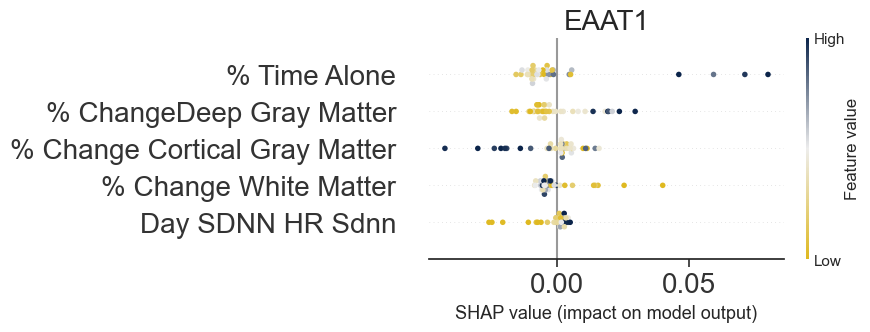

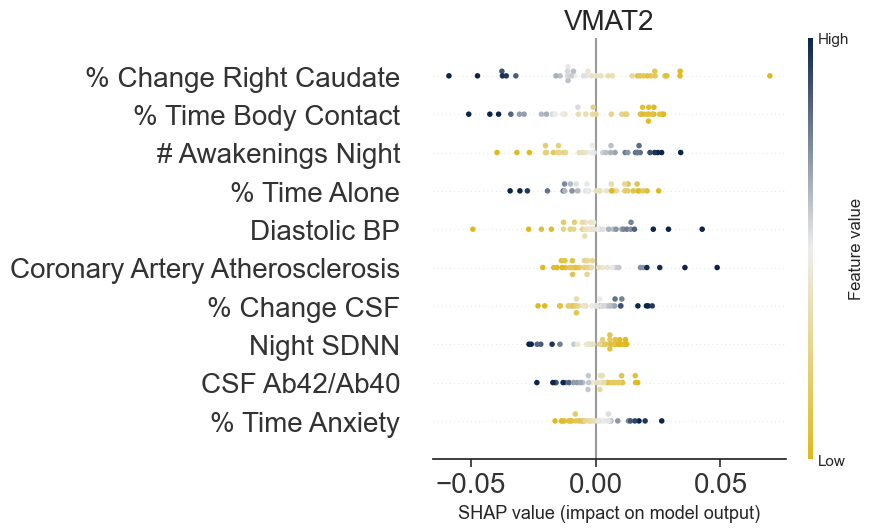

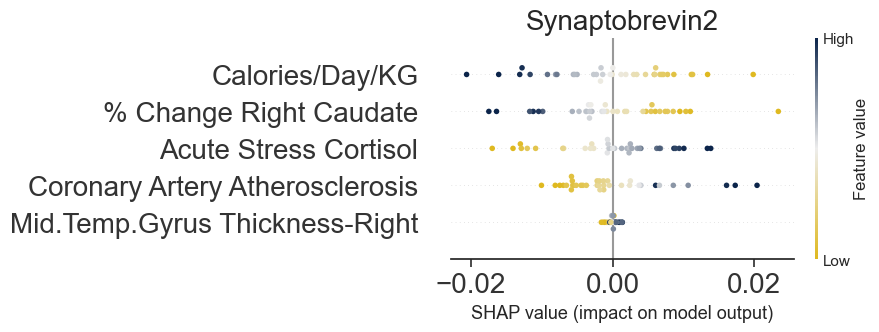

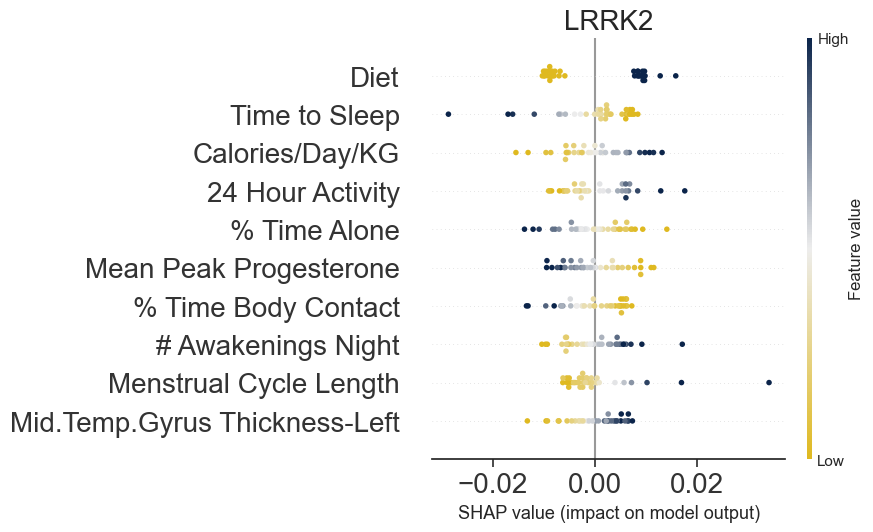

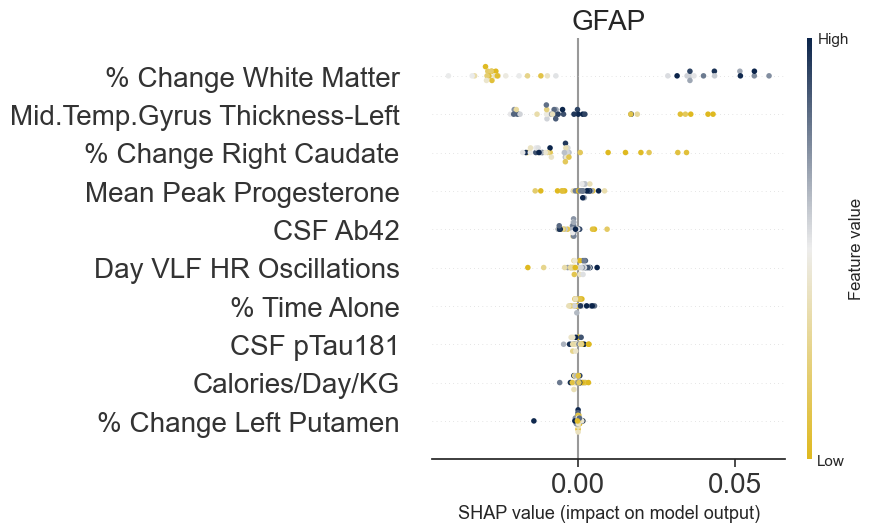

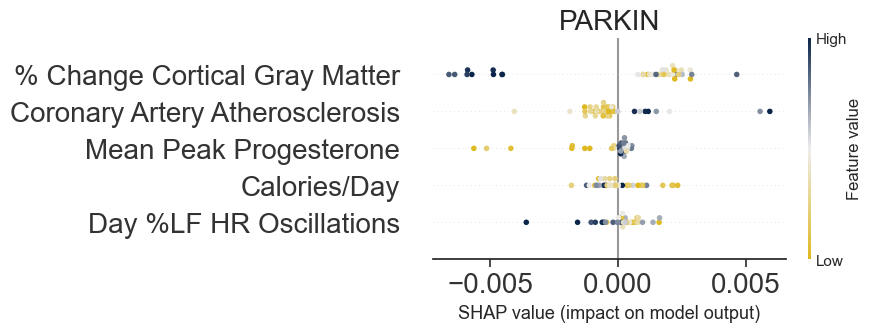

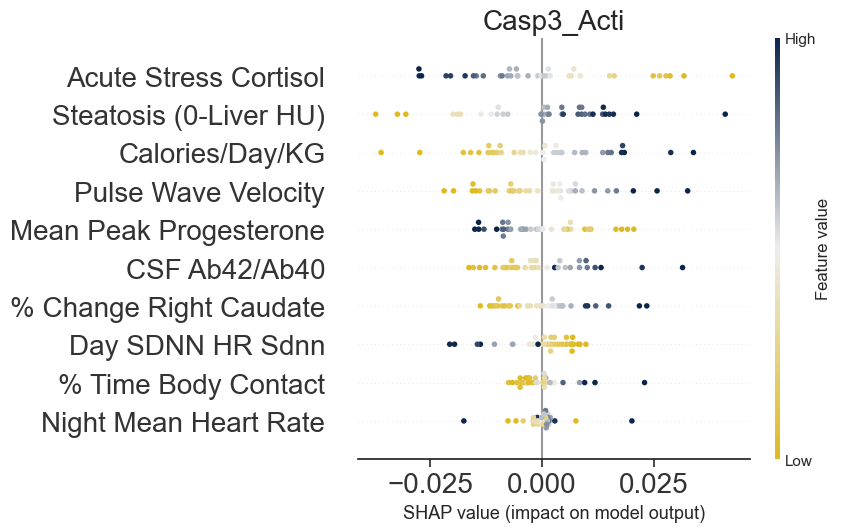

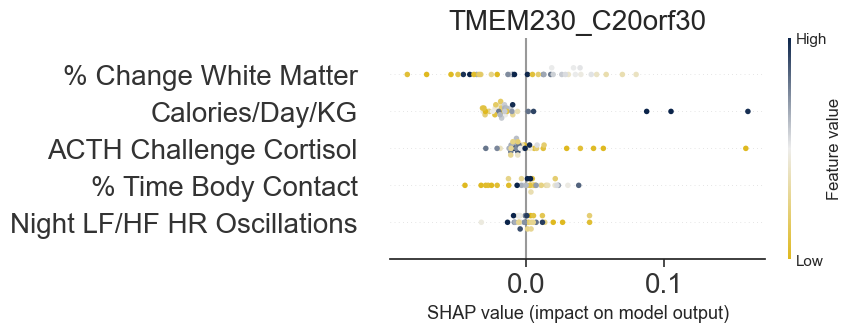

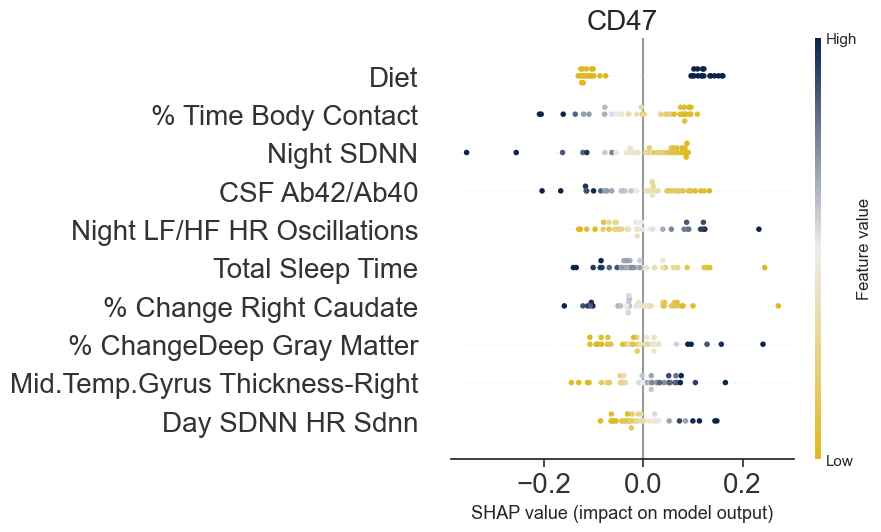

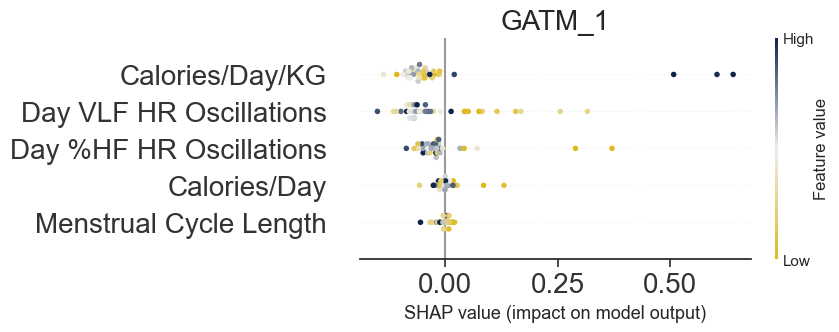

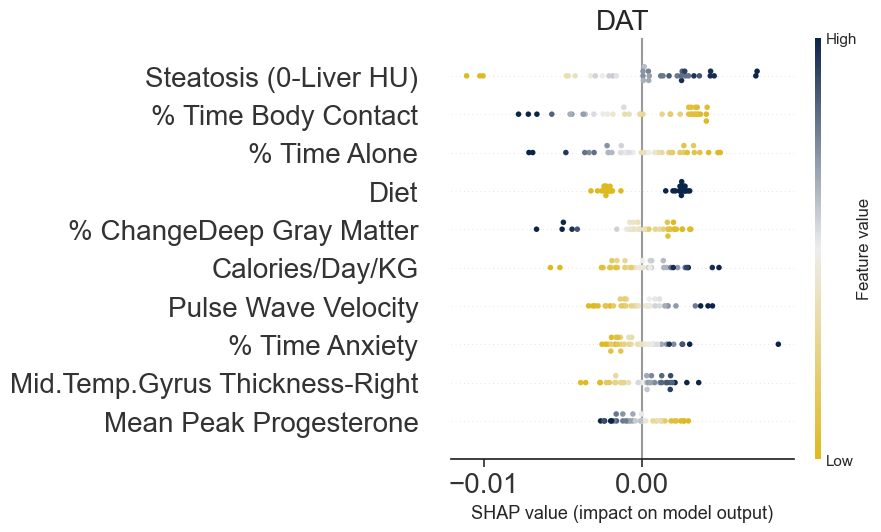

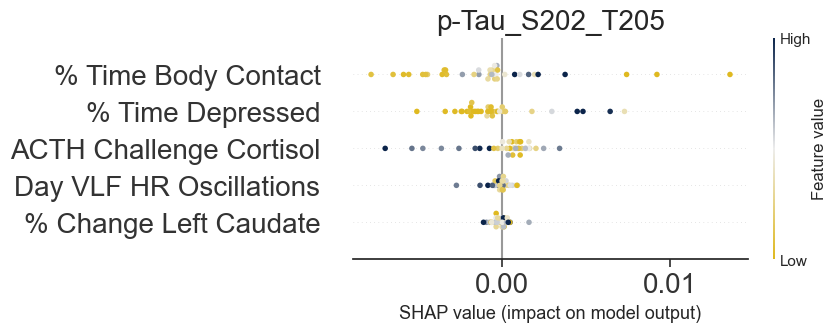

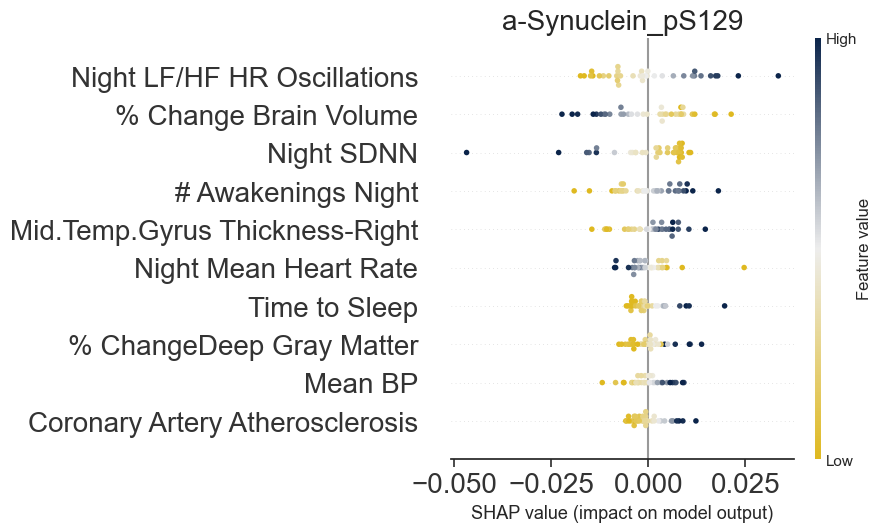

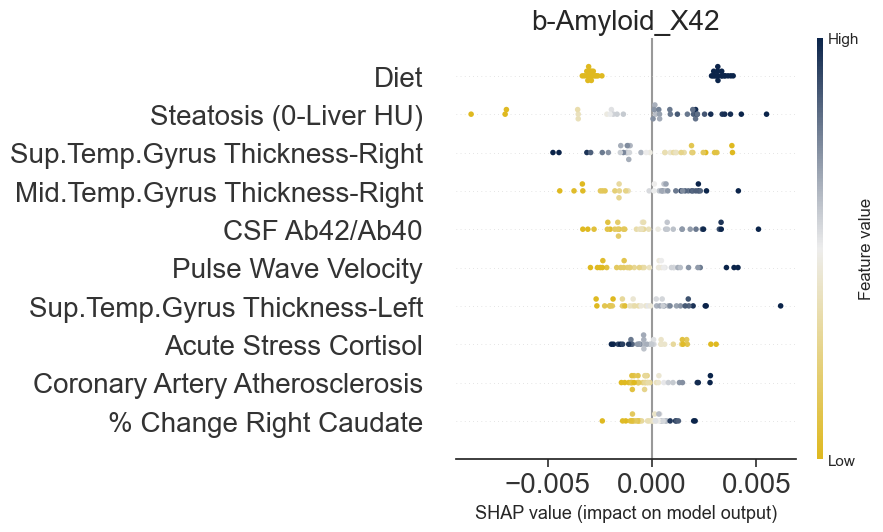

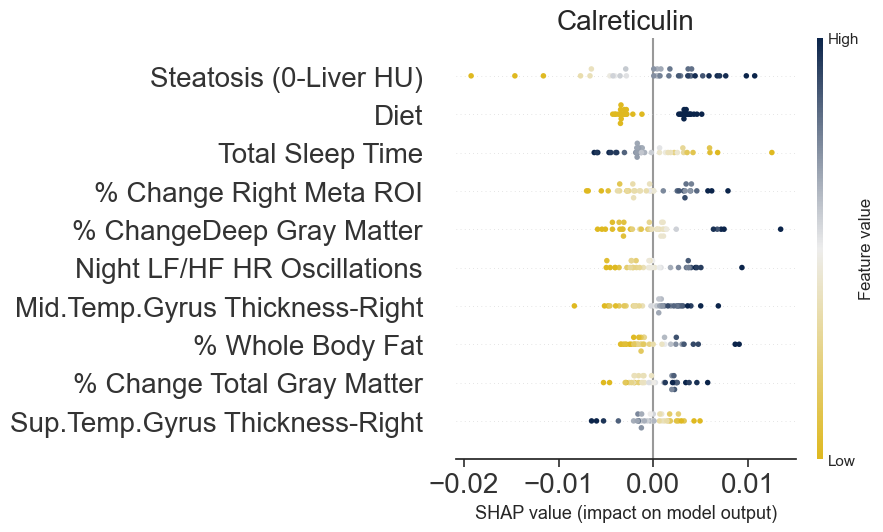

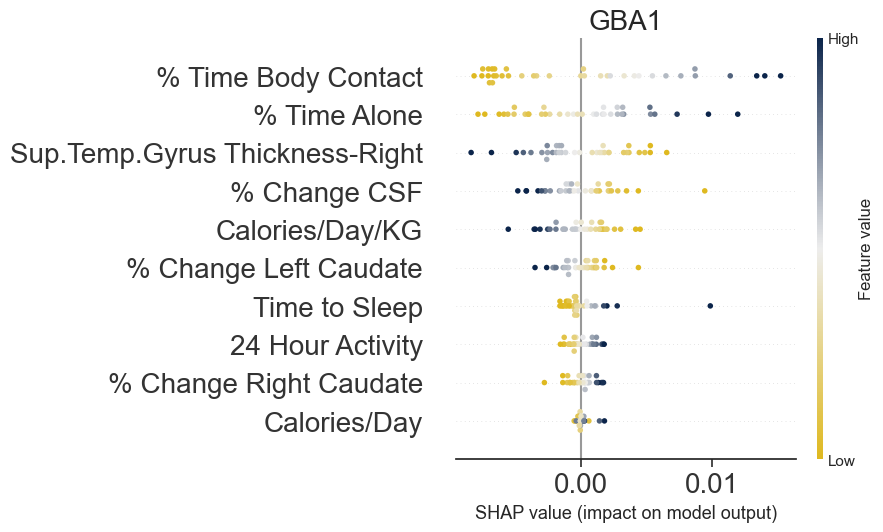

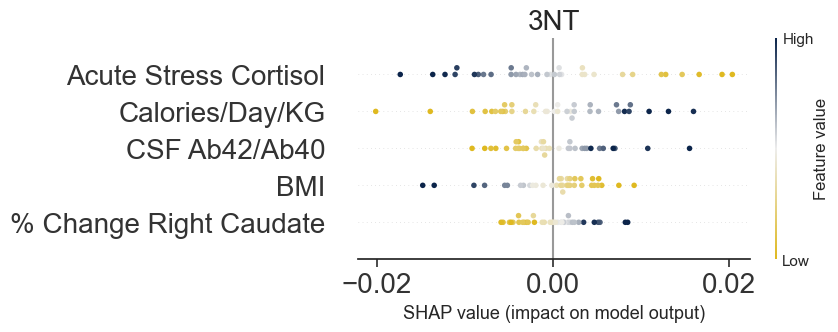

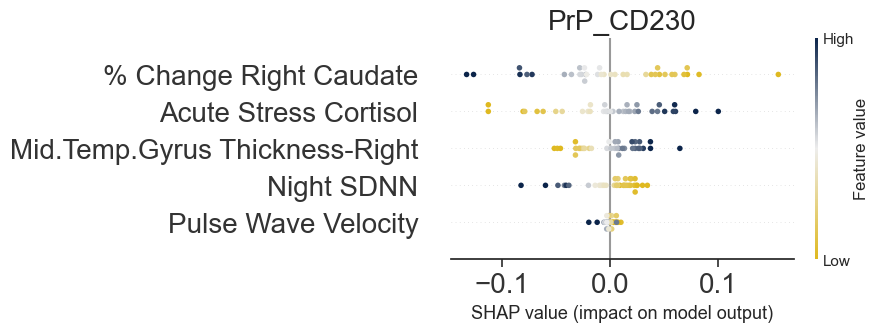

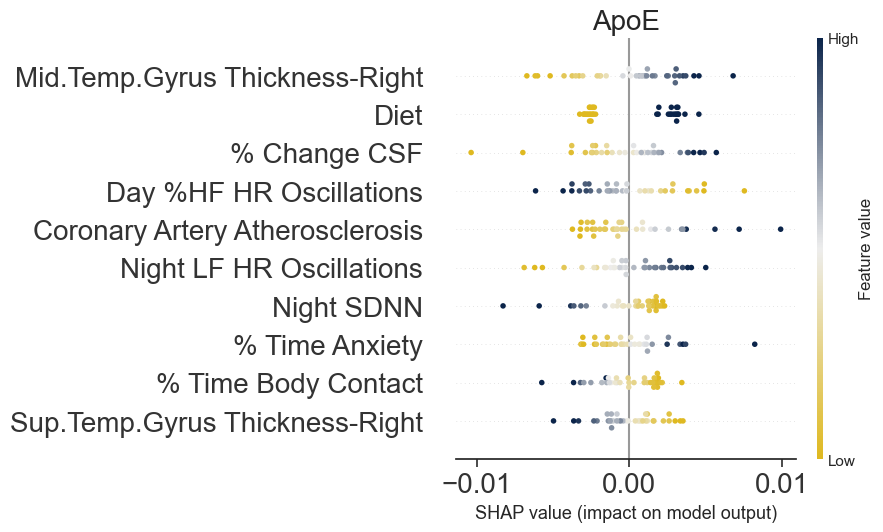

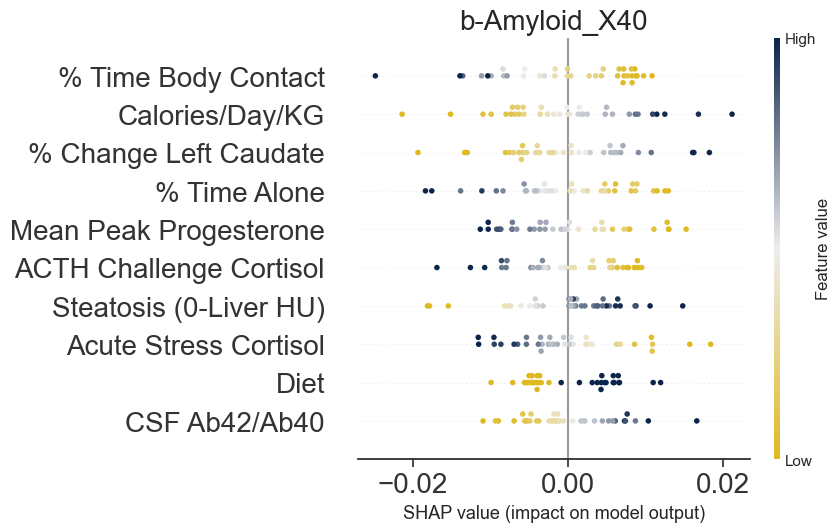

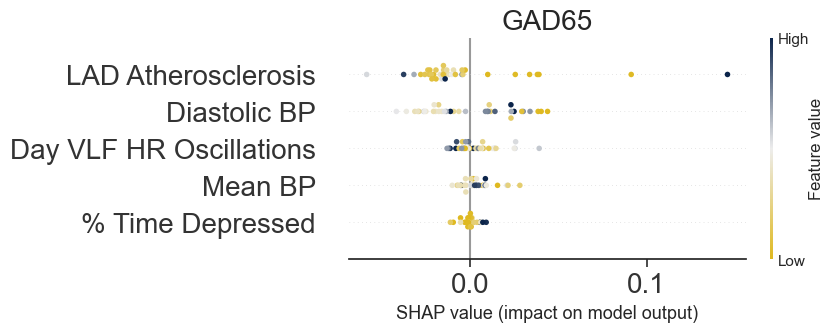

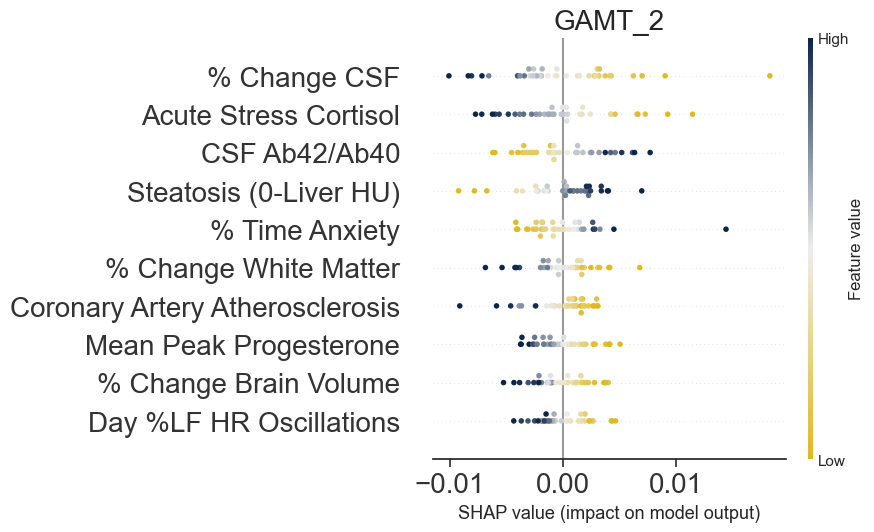

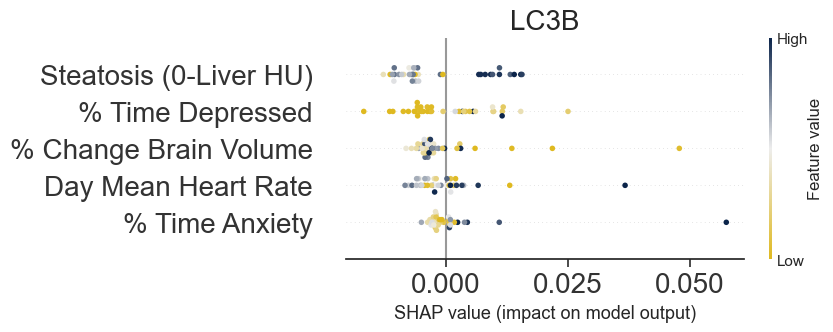

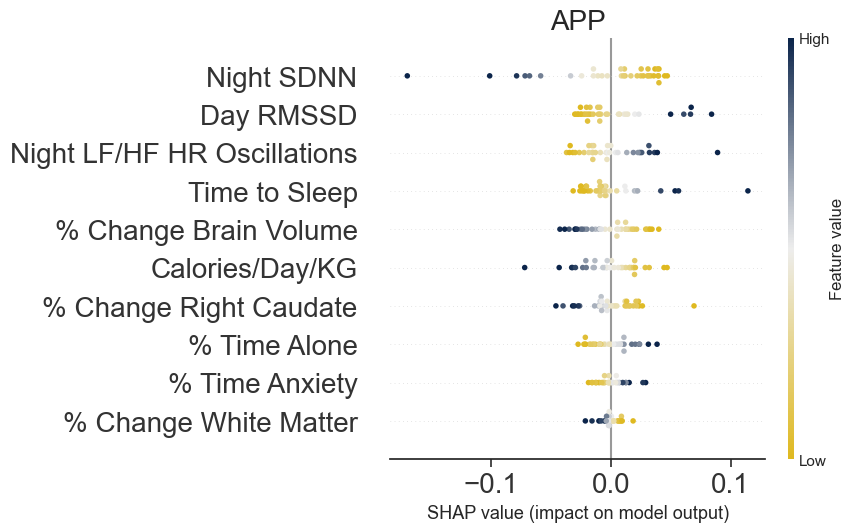

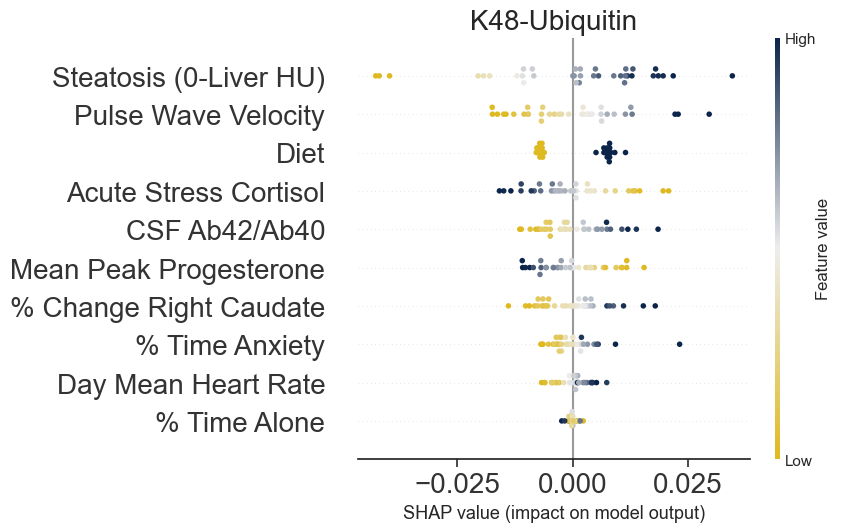

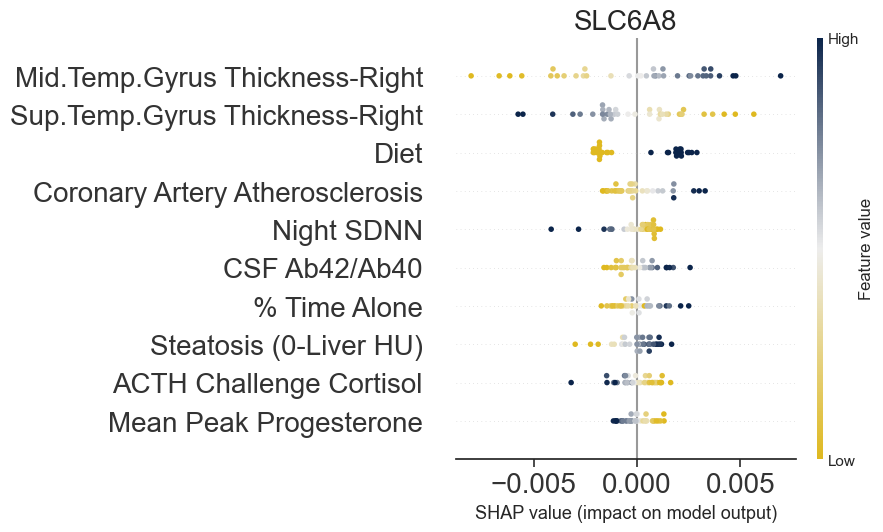

In [36]:
shap_mean_val ={}
shap_std_val ={}
shap_range_val ={}
for it in shap_values_per_cv.keys():
    # Establish lists to keep average Shap values, their Stds, and their min and max
    average_shap_values, stds, ranges = [],[],[]
    shap_dico = shap_values_per_cv[it]
    for i in range(0,len(X)):
        df_per_obs = pd.DataFrame.from_dict(shap_dico[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=0).values) 
        stds.append(df_per_obs.std(axis=0).values)
        ranges.append(df_per_obs.max(axis=0).values-df_per_obs.min(axis=0).values)
    shap_mean_val[it] = np.array(average_shap_values)
    shap_std_val[it] = np.array(stds)
    shap_range_val[it] = np.array(ranges)



# fig_savedir = savedir + "feat_importance_with_feat_selection"
# if not os.path.exists(fig_savedir):
#     os.mkdir(fig_savedir)


import shap
from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", '#EDEDED', "#0b244a"], N=256)
plt.register_cmap(cmap=mycmap)
for it in shap_mean_val.keys():
    plt.figure()
    xx =  meta[com].iloc[:,np.where(all_weight_index.loc[it]==1)[0]]
   
    shap.summary_plot(shap_mean_val[it],xx, show = False,max_display=10)#, plot_type="bar")
    # plt.title('%s: Average SHAP values after 10x cross-validation'%it.split("_(")[0].split("_",2)[-1])
    plt.title(it.split("_(")[0].split("_",2)[-1],fontsize=20)

    # Change the colormap of the artists
    plt.set_cmap(mycmap)
    for fc in plt.gcf().get_children():
        for fcc in fc.get_children():
            if hasattr(fcc, "set_cmap"):
                fcc.set_cmap(mycmap)
  
#                 # fcc.tick_params(labelsize=20)
    plt.tick_params(labelsize=20)
    # plt.xlabel("SHAP value (impact on model output)",fontsize=20)
    # plt.savefig(os.path.join(fig_savedir, "shap_value_feat_70_with_diet_%s.svg"%it))
    plt.show()

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/2332561040.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


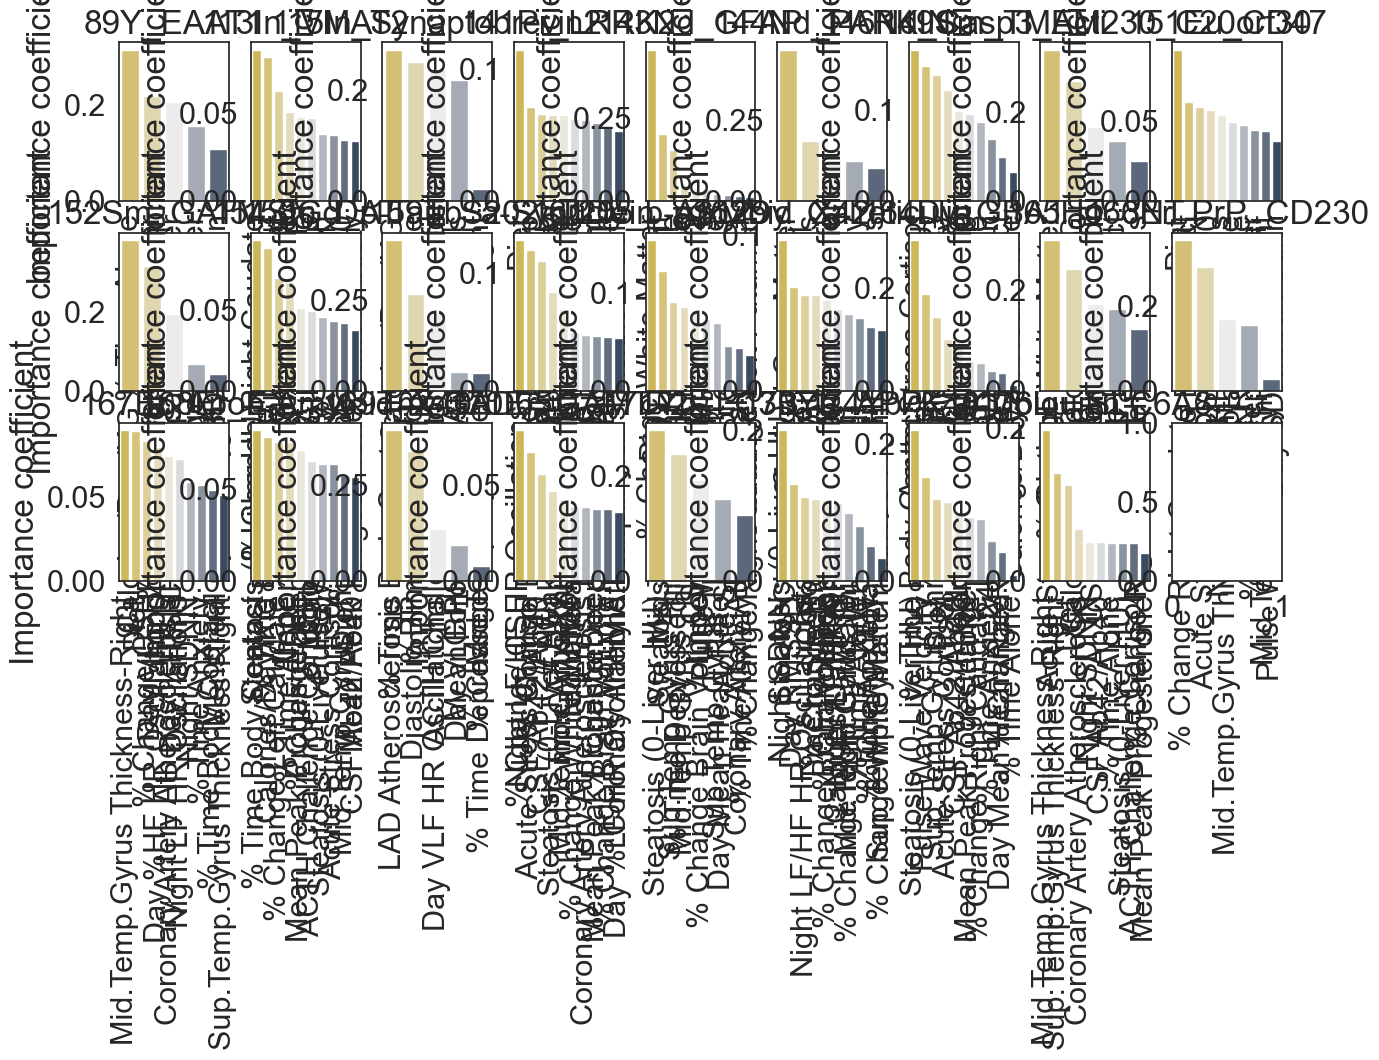

In [37]:
wt = shap_mean_val
fig, axes = plt.subplots(3,9, figsize=(15, 7))
axes = axes.flatten()
for ii,it in enumerate(final.index.tolist()):
    ax= axes[ii]
    my_cmap = plt.get_cmap("Blues")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    xx =  meta[com].iloc[:,np.where(all_weight_index.loc[it]==1)[0]]
    feat_importances = pd.DataFrame(np.abs(wt[it]).mean(0)/ (np.abs(wt[it]).mean(0).sum()), index=xx.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True, )
    # y = feat_importances["Importance"][:20]#.values()
    data = feat_importances[:10].reset_index()
    sns.barplot(data=data,x="index", y="Importance", 
                ax=ax, palette="mycmapd")
    ax.set_title(it.split("_(")[0].split("_",1)[1])
    ax.set_ylabel("Importance coefficient")
    xla = [it.get_text() for it in ax.get_xticklabels()]
    ax.set_xticklabels(xla, rotation=90)
    ax.set_xlabel("")
   # ax.get_legend().remove()
plt.tight_layout()
# plt.savefig(savedir + "best_åçmodel_20_features_importance_70_no_selection.svg")

plt.show()

61


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/2054066672.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  to_plot.fillna(0, inplace=True)


(1560, 3)

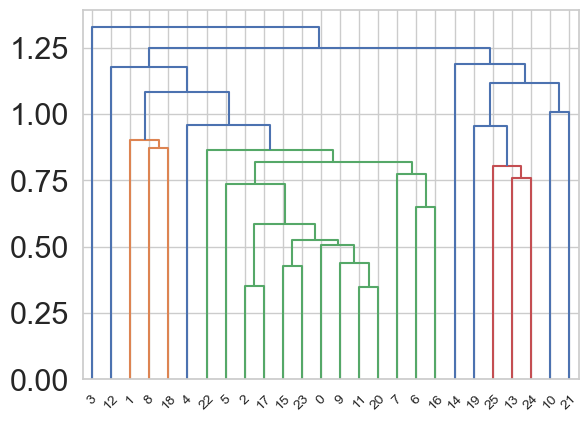

In [57]:
feat_importance = pd.DataFrame(columns=meta[com].columns.tolist())
n_features = 30
for ii,it in enumerate(final.index.tolist()):
    marker = it.split("_(")[0].split("_",2)[-1]
    w_best = np.abs(wt[it]).mean(0)/ (np.abs(wt[it]).mean(0).sum()).tolist()
    #indx = sorted(range(len(w_best)), key=lambda i: w_best[i])[-n_features:]
    #no_sel = [it for it in range(len(w_best)) if not it in indx]
    #w_best[no_sel] = 0
    xx =  meta[com].iloc[:,np.where(all_weight_index.loc[it]==1)[0]]
    feat_importance.loc[marker, xx.columns.tolist()] = w_best
# feat_importance[feat_importance<= 0.001] = 0

to_plot = feat_importance.loc[:,feat_importance.sum(0) !=0]

to_plot.fillna(0, inplace=True)

to_plot = to_plot.stack().reset_index(name="mean(|SHAP value|)")

from scipy.stats import pearsonr, spearmanr
import numpy as np
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", 'white', "#0b244a"], N=256)
hh = meta[com + final["marker"].unique().tolist()]
rho = hh.corr(method="spearman")
feat_corr = rho.loc[final["marker"].unique().tolist(), com]
feat_corr.index = [it.split("_(",1)[0].split("_",1)[-1] for it in feat_corr.index.tolist()]
mask = final_wight.loc[feat_corr.index.tolist(), ]
feat_corr =mask.values*feat_corr
to_keep = feat_corr.sum(0)[feat_corr.sum(0)!=0].index.tolist()
feat_corr = feat_corr[to_keep]
print(len(to_keep))
if "Diet" in to_keep:
    to_keep.remove("Diet")
    feat_corr.drop("Diet", axis=1, inplace=True)
row_linkage = hierarchy.linkage(
    distance.pdist(feat_corr.values), method='average')
dn = dendrogram(row_linkage)
list_rows = feat_corr.index.tolist()
feat_corr = feat_corr.stack().reset_index(name="Spearman Correlation")
feat_corr.shape

In [58]:
to_plot = to_plot.merge(feat_corr, on=["level_0","level_1"])

order_col = mapi[mapi["New Definitions"].isin(to_keep)].sort_values("Final Reorder")["New Definitions"].values

order_row = np.asarray(list_rows)[np.asarray(dn["leaves"]).astype(int)]
order_row
print(len(order_col))
sorterIndex = dict(zip(order_row, range(len(order_row))))
to_plot['order_row'] = to_plot['level_0'].map(sorterIndex)

sorterIndex = dict(zip(order_col, range(len(order_col))))
to_plot['order_col'] = to_plot['level_1'].map(sorterIndex)
to_plot = to_plot.sort_values(["order_col", "order_row"])
to_plot

60


level_0           level_1  mean(|SHAP value|)  \
239               LRRK2    % Time Anxiety            0.000000   
779   a-Synuclein_pS129    % Time Anxiety            0.017251   
119               VMAT2    % Time Anxiety            0.034204   
539                CD47    % Time Anxiety            0.006786   
1139               ApoE    % Time Anxiety            0.057070   
...                 ...               ...                 ...   
1518             SLC6A8  CSF pTau181/Ab42            0.000000   
798       b-Amyloid_X42  CSF pTau181/Ab42            0.000000   
1458      K48-Ubiquitin  CSF pTau181/Ab42            0.000000   
618                 DAT  CSF pTau181/Ab42            0.000000   
1278             GAMT_2  CSF pTau181/Ab42            0.009752   

      Spearman Correlation  order_row  order_col  
239              -0.000000          0          0  
779              -0.115058          1          0  
119               0.218275          2          0  
539               0.078764          3          0  
1139              0.048391          4          0  
...                    ...        ...        ...  
1518             -0.000000         21         59  
798              -0.000000         22         59  
1458             -0.000000         23         59  
618              -0.000000         24         59  
1278             -0.212870         25         59  

[1560 rows x 6 columns]

In [59]:
[it for it in feat_corr.level_1.unique().tolist() if it not in order_col]

[]

In [60]:
map_marker = {it.split("_(",1)[0].split("_",1)[-1]: it for it in final["marker"].unique().tolist()}

In [61]:
#ll =feat_corr.stack().reset_index()
to_plot=to_plot[to_plot["mean(|SHAP value|)"] !=0]
ll = to_plot[to_plot["Spearman Correlation"]!=0] #ll[ll[0]!=0]
pvals_ = []
for it in ll.iterrows():
    
    sp, pv = spearmanr(meta[map_marker[it[1].loc["level_0"]]], meta[it[1].loc["level_1"]])
    #print(np.abs(sp-it[1][0])) #<1e-5)
    pvals_.append(pv)

ll["pval"] = pvals_
ll
to_plot = ll
from statsmodels.stats.multitest import multipletests
qvalue  =multipletests(to_plot["pval"].values, method="fdr_bh")[1]
to_plot["Adjusted Pvalue"] = qvalue
to_plot

level_0                 level_1  mean(|SHAP value|)  \
779   a-Synuclein_pS129          % Time Anxiety            0.017251   
119               VMAT2          % Time Anxiety            0.034204   
539                CD47          % Time Anxiety            0.006786   
1139               ApoE          % Time Anxiety            0.057070   
1379               LC3B          % Time Anxiety            0.126003   
...                 ...                     ...                 ...   
606                 DAT  Steatosis (0-Liver HU)            0.092424   
1266             GAMT_2  Steatosis (0-Liver HU)            0.047112   
601                 DAT      IV GTT Insulin AUC            0.019171   
1261             GAMT_2      IV GTT Insulin AUC            0.006248   
1278             GAMT_2        CSF pTau181/Ab42            0.009752   

      Spearman Correlation  order_row  order_col      pval  Adjusted Pvalue  
779              -0.115058          1          0  0.504001         0.860201  
119               0.218275          2          0  0.200925         0.599843  
539               0.078764          3          0  0.647945         0.892215  
1139              0.048391          4          0  0.779274         0.945766  
1379             -0.039125          6          0  0.820773         0.953682  
...                    ...        ...        ...       ...              ...  
606               0.618533         24         57  0.000058         0.008824  
1266              0.442471         25         57  0.006888         0.176081  
601              -0.311454         24         58  0.064448         0.403720  
1261             -0.326384         25         58  0.052045         0.401628  
1278             -0.212870         25         59  0.212584         0.612303  

[409 rows x 8 columns]

In [66]:

to_plot.rename(columns={"level_0":"SynTOF markers", "level_1":"Phenotypes",
                "pval":"Raw P-value", "Adjusted Pvalue":"Adjusted P-value"},inplace=True)
to_plot.drop(["order_row", "order_col"], axis=1).to_csv(savedir + "Supp Table5.csv", index=None)
to_plot


SynTOF markers              Phenotypes  mean(|SHAP value|)  \
779   a-Synuclein_pS129          % Time Anxiety            0.017251   
119               VMAT2          % Time Anxiety            0.034204   
539                CD47          % Time Anxiety            0.006786   
1139               ApoE          % Time Anxiety            0.057070   
1379               LC3B          % Time Anxiety            0.126003   
...                 ...                     ...                 ...   
606                 DAT  Steatosis (0-Liver HU)            0.092424   
1266             GAMT_2  Steatosis (0-Liver HU)            0.047112   
601                 DAT      IV GTT Insulin AUC            0.019171   
1261             GAMT_2      IV GTT Insulin AUC            0.006248   
1278             GAMT_2        CSF pTau181/Ab42            0.009752   

      Spearman Correlation  order_row  order_col  Raw P-value  \
779              -0.115058          1          0     0.504001   
119               0.218275          2          0     0.200925   
539               0.078764          3          0     0.647945   
1139              0.048391          4          0     0.779274   
1379             -0.039125          6          0     0.820773   
...                    ...        ...        ...          ...   
606               0.618533         24         57     0.000058   
1266              0.442471         25         57     0.006888   
601              -0.311454         24         58     0.064448   
1261             -0.326384         25         58     0.052045   
1278             -0.212870         25         59     0.212584   

      Adjusted P-value  
779           0.860201  
119           0.599843  
539           0.892215  
1139          0.945766  
1379          0.953682  
...                ...  
606           0.008824  
1266          0.176081  
601           0.403720  
1261          0.401628  
1278          0.612303  

[409 rows x 8 columns]

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_48107/2615044574.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=90)


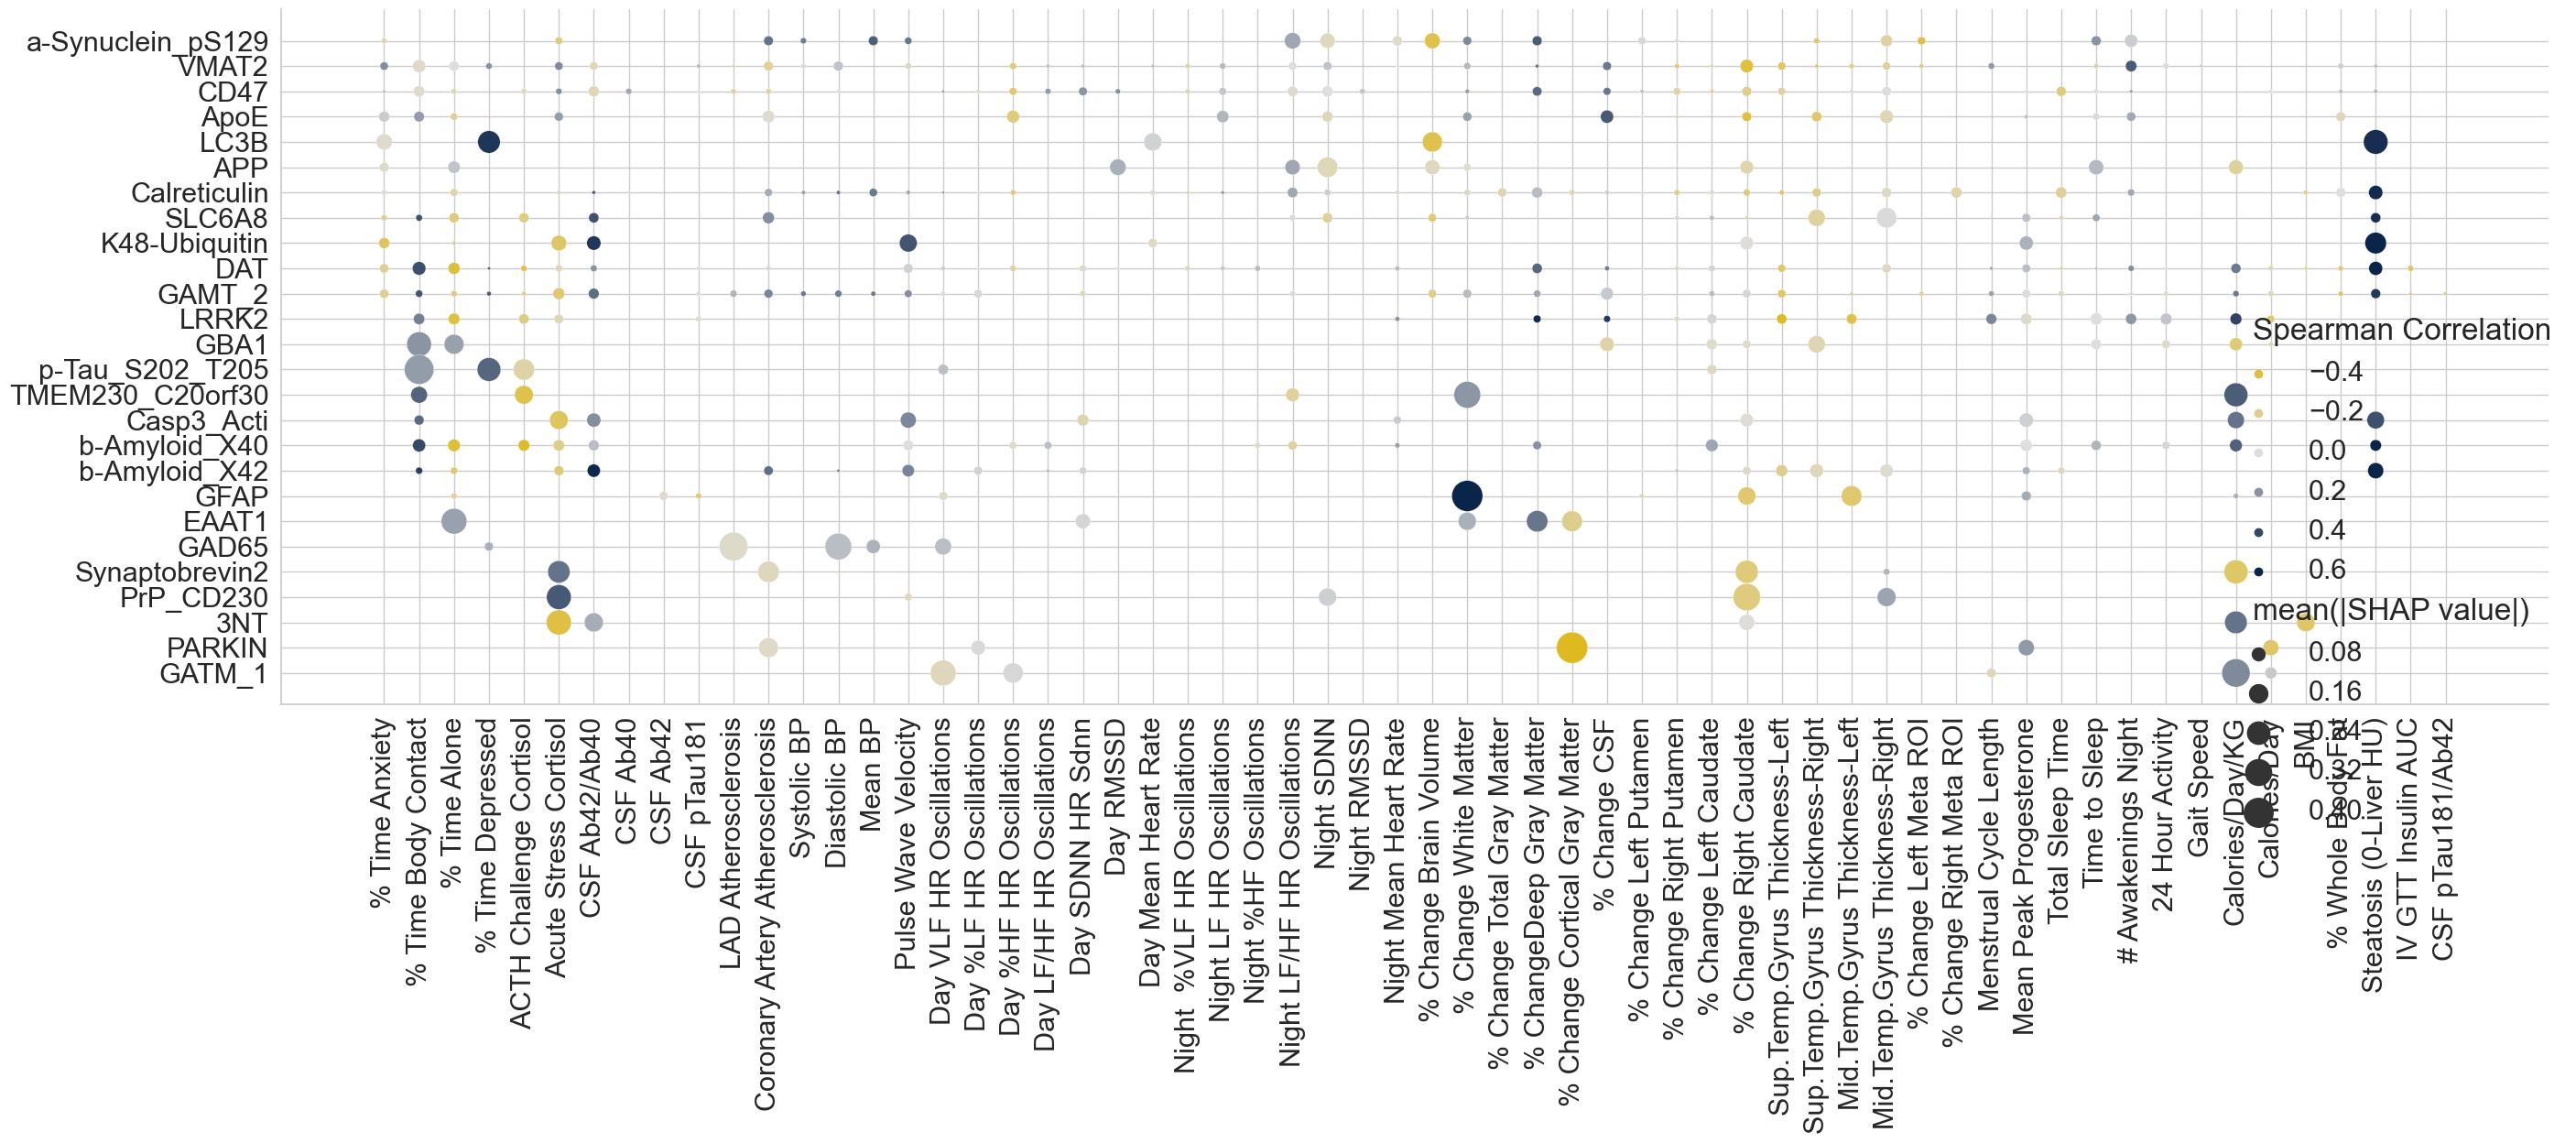

In [67]:
# fig, ax = plt.subplots(figsize=(35, 10))
mycmap2 = LinearSegmentedColormap.from_list("mycmapd", ["#dfb920", '#DEDEDE', "#0b244a"], N=256)
# plt.register_cmap(cmap=mycmap)
sns.set(style="whitegrid",font_scale=2)
# to_plot["level_1"] = to_plot["level_1"].str.replace(" ","")
# to_plot["level_1"] = to_plot["level_1"].str.replace("","")
g = sns.relplot(data=to_plot, y="SynTOF markers", x="Phenotypes", hue="Spearman Correlation", size="mean(|SHAP value|)", palette=mycmap2,#ax=ax,
           height=13, aspect=1.9, sizes=(1, 600), hue_norm=(-0.5,0.5), row_order=order_row.tolist(), col_order=order_col)#,  linewidth=0.2, vmin=-0.5, vmax=0.5,
                    # cbar_kws={"shrink":0.2, "label":"Spearman correlation","orientation":'horizontal' })#, annot=p, fmt="s",)
# gg.ax_cbar.set_position([0, 0.95, gg.ax_row_dendrogram.get_position().width, 0.02])

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=90)
# plt.legend(bbox_to_anchor=(1, 0.2))
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig(savedir + "Figure4C.svg")

plt.show()

# sns.relplot(to_plot, y="level_0", x="level_1",  size="significant", color="red",ax=g,markers=["o"], #palette=mycmap2,#ax=ax,
#            height=13, aspect=1.9, sizes=(20, 0), hue_norm=(-0.5,0.5), row_order=order_row.tolist(), col_order=order_col)
# g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=90)
# plt.legend(bbox_to_anchor=(1, 0.2))
# plt.xlabel("")
# plt.ylabel("")
# plt.tight_layout()
# plt.savefig(savedir + "univaritate_shap_pheno_pvalue.svg")

# plt.show()